In [ ]:
!pip install pyclesperanto_prototype

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.0/624.0 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 724.6/724.6 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extended Depth of Field (EDF) for 4D Microscopy Images
Running all EDF methods with and without tophat background removal

Applying all EDF methods to each image:
1. Laplacian EDF (best for most confocal data)
2. Sobel Variance EDF (good for structures with clear edges)
3. Normalized Variance EDF (good for varying contrast regions)
4. Multi-scale EDF (combines information at different scales)
5. Map Fusion EDF (produces focus maps, good for complex structures)

Each method will be applied both with and without tophat background removal

Generating comparison visualization for first image: trial.tif
Testing EDF methods with and without tophat on trial.tif, channel 1...
Testing Laplacian EDF...
Testing Sobel Variance EDF...
Testing Normalized Variance EDF...
Testing Multi-scale EDF...
Testing Map Fusion EDF...


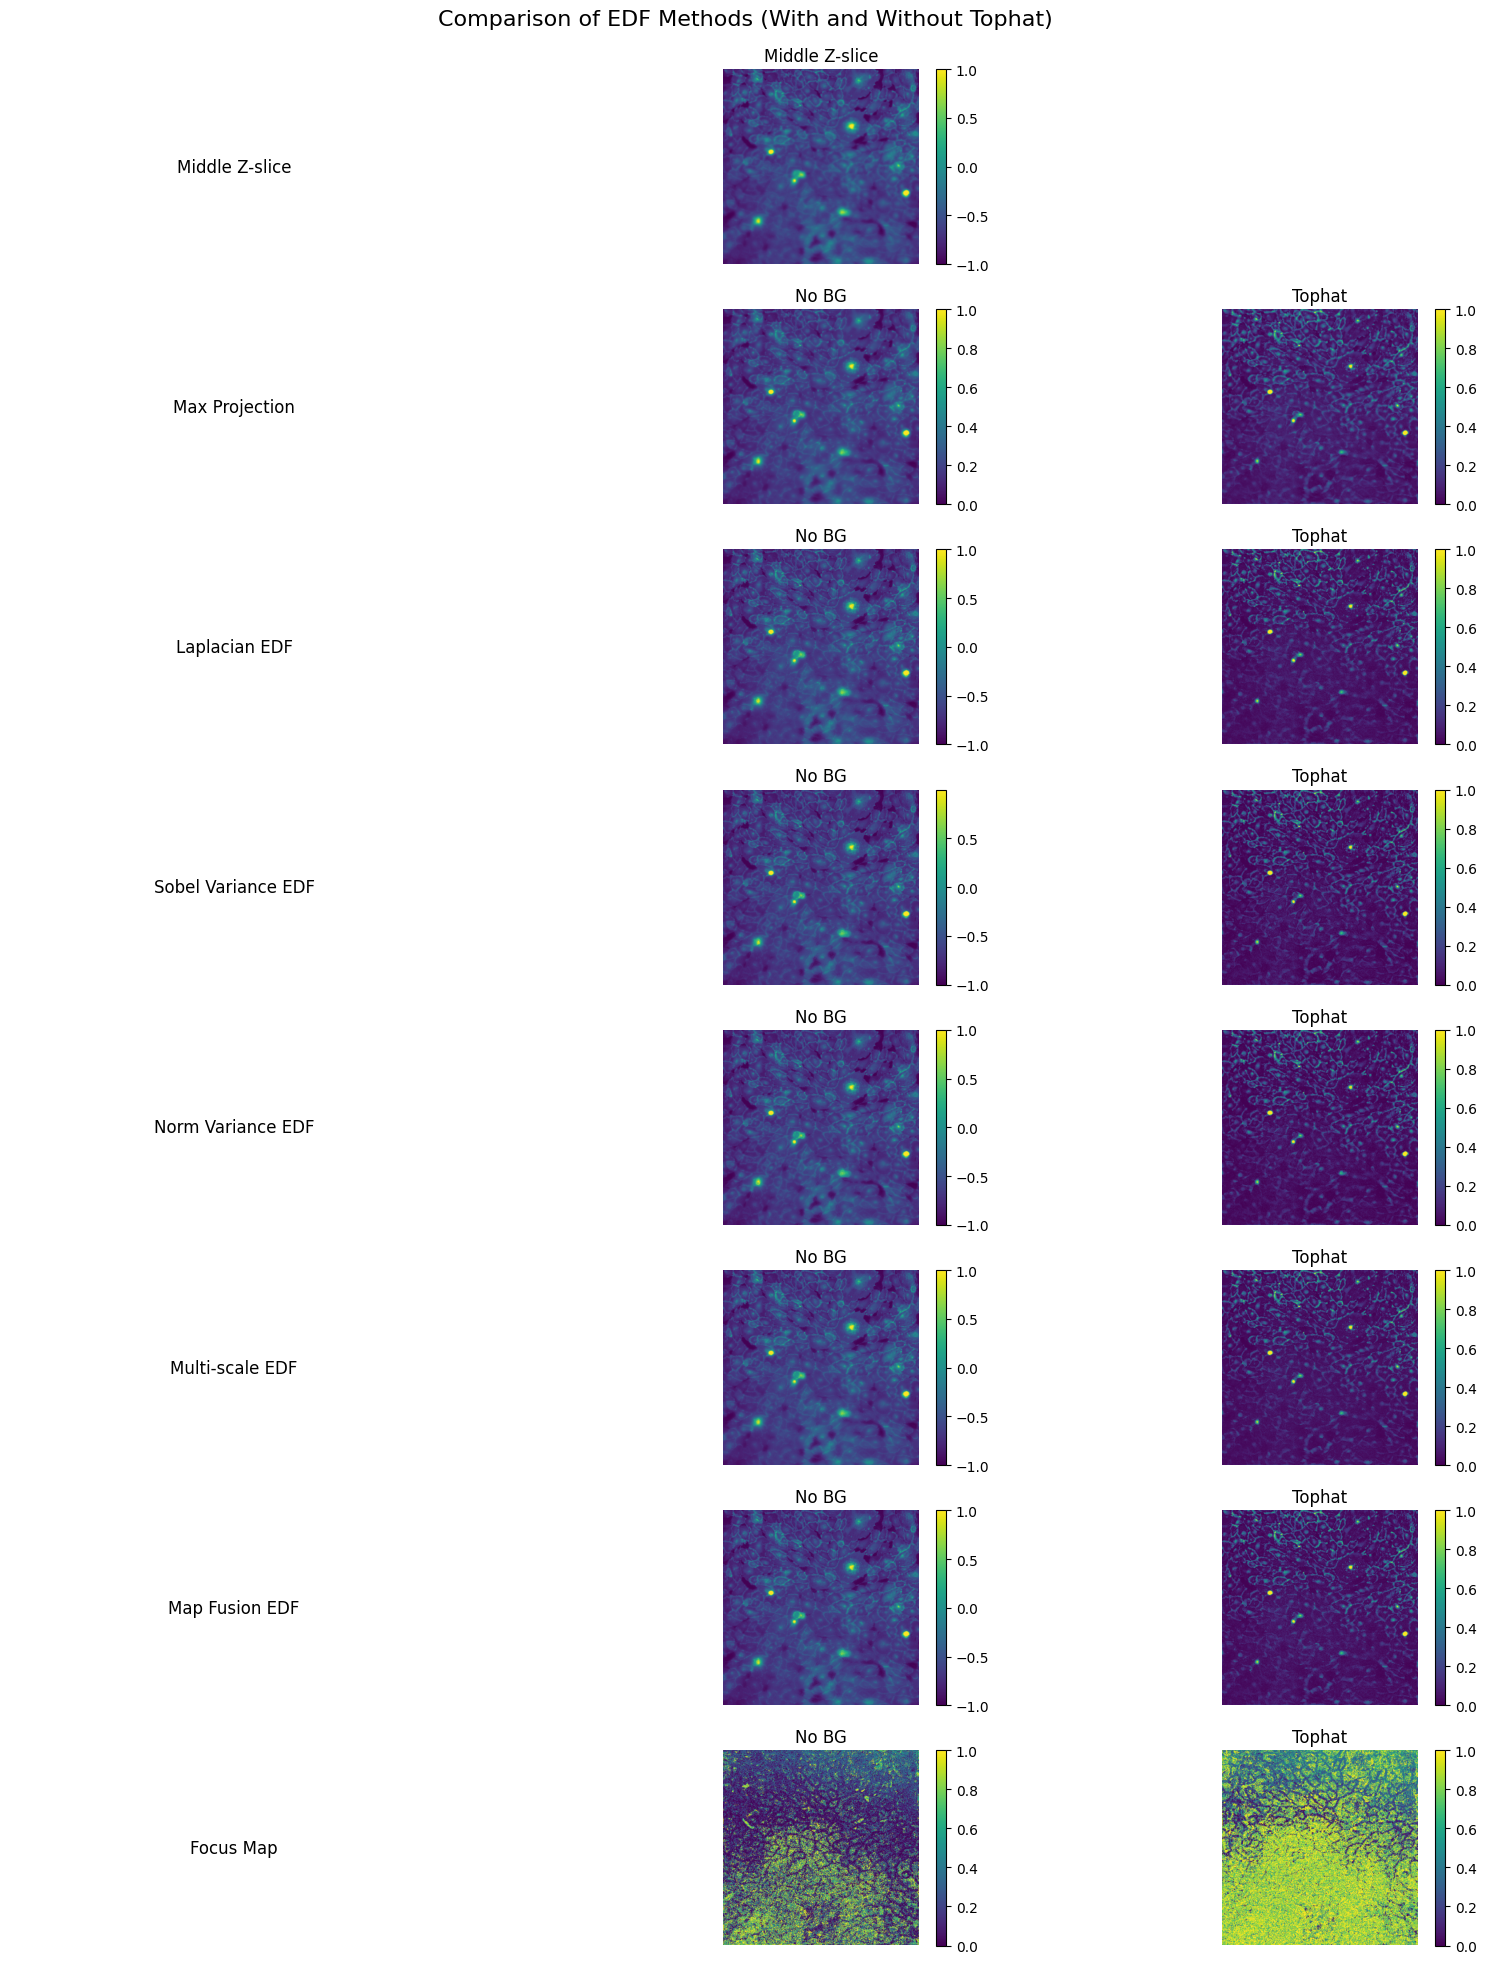


Processing all images with all EDF methods (with and without tophat)...
Found 1 image files. Processing with ALL EDF methods...
Processing image 1/1: trial.tif
  Image shape: (3, 13, 1024, 1024), dtype: float32
  Processing 4D image with shape (3, 13, 1024, 1024)
  Normalizing image values from range [-0.034448783844709396, 5.7295918464660645] to [0, 1]
  Applying tophat background removal to Cadherins channel...
  Applying laplacian EDF projection to Cadherins channel (tophat)...
  Applying sobel EDF projection to Cadherins channel (tophat)...
  Applying variance EDF projection to Cadherins channel (tophat)...
  Applying multiscale EDF projection to Cadherins channel (tophat)...
  Applying fusion EDF projection to Cadherins channel (tophat)...
  Processing Cadherins channel without background removal...
  Applying laplacian EDF projection to Cadherins channel (nobg)...
  Applying sobel EDF projection to Cadherins channel (nobg)...
  Applying variance EDF projection to Cadherins chann

In [4]:
# Improved Extended Depth of Field (EDF) for Multichannel Confocal Z-Stacks
# Based on user's existing workflow but with enhanced projection methods

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
from skimage import io, filters, exposure, restoration, img_as_float, img_as_uint, measure
from skimage import morphology
from scipy import ndimage
import glob
import tifffile
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Define input and output paths
input_dir = '/content/drive/MyDrive/knowledge/University/Master/Thesis/denoised/trial'
output_dir = '/content/drive/MyDrive/knowledge/University/Master/Thesis/Projected/trial9'

# Define channel names
channel_names = ['Cadherins', 'Nuclei', 'Golgi']

# Create output directories for each channel
for channel_name in channel_names:
    channel_dir = os.path.join(output_dir, channel_name)
    os.makedirs(channel_dir, exist_ok=True)

# ======= UTILITY FUNCTIONS =======

def normalize_image(img):
    """Normalize image to 0-1 range"""
    img_min = np.min(img)
    img_max = np.max(img)
    if img_max > img_min:
        return (img - img_min) / (img_max - img_min)
    return img

def display_image_with_histogram(image, title="Image"):
    """Display an image with its histogram"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Display image
    im = ax1.imshow(image, cmap='viridis')
    ax1.set_title(title)
    ax1.axis('off')
    plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)

    # Display histogram
    ax2.hist(image.ravel(), bins=256, histtype='step', color='blue')
    ax2.set_title('Histogram')
    ax2.set_xlabel('Pixel Value')
    ax2.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# ======= BACKGROUND REMOVAL METHODS =======

def tophat_filter_background(image, radius=15):
    """
    Remove background using white top-hat filter

    Parameters:
    -----------
    image : numpy.ndarray
        Input image
    radius : int
        Radius of the disk-shaped structuring element

    Returns:
    --------
    numpy.ndarray
        Background-removed image
    """
    # Normalize input
    img = img_as_float(image)

    # Create structuring element (disk)
    selem = morphology.disk(radius)

    # Apply white top-hat filter (removes background while preserving foreground)
    tophat = morphology.white_tophat(img, selem)

    # Enhance contrast
    tophat = exposure.rescale_intensity(tophat)

    return tophat

# ======= IMPROVED PROJECTION METHODS =======

def advanced_edf_laplacian(image_stack, sigma=1.0, gauss_denoise=1.0):
    """
    Enhanced Extended Depth of Field using Laplacian-based focus measure

    Parameters:
    -----------
    image_stack : numpy.ndarray
        Stack of images with shape (z, y, x)
    sigma : float
        Sigma for Laplacian operator smoothing
    gauss_denoise : float
        Sigma for Gaussian denoising

    Returns:
    --------
    numpy.ndarray
        EDF projected image
    """
    # Convert to float and ensure correct range
    stack = img_as_float(image_stack)

    z_size, height, width = stack.shape
    result = np.zeros((height, width), dtype=np.float32)

    # Calculate focus measure using Laplacian
    focus_measures = np.zeros((z_size, height, width))

    for z in range(z_size):
        # Apply Gaussian filter to reduce noise
        if gauss_denoise > 0:
            blurred = filters.gaussian(stack[z], sigma=gauss_denoise)
        else:
            blurred = stack[z]

        # Apply Laplacian filter (detects edges/details)
        laplacian = np.abs(filters.laplace(blurred, ksize=3))

        # Apply small Gaussian to make the decision more robust
        if sigma > 0:
            focus_measures[z] = filters.gaussian(laplacian, sigma=sigma)
        else:
            focus_measures[z] = laplacian

    # Find the z-slice with maximum focus for each pixel
    best_z = np.argmax(focus_measures, axis=0)

    # Create output by taking pixels from best z-slices
    for z in range(z_size):
        mask = best_z == z
        result[mask] = stack[z][mask]

    return result

def edf_sobel_variance(image_stack, window_size=5, sigma=1.0):
    """
    Extended Depth of Field using Sobel gradient variance

    Parameters:
    -----------
    image_stack : numpy.ndarray
        Stack of images with shape (z, y, x)
    window_size : int
        Size of window for variance calculation
    sigma : float
        Sigma for Gaussian smoothing

    Returns:
    --------
    numpy.ndarray
        EDF projected image
    """
    # Convert to float
    stack = img_as_float(image_stack)

    z_size, height, width = stack.shape
    result = np.zeros((height, width), dtype=np.float32)

    # Calculate focus measure using Sobel variance
    focus_measures = np.zeros((z_size, height, width))

    for z in range(z_size):
        # Apply Gaussian filter to reduce noise
        blurred = filters.gaussian(stack[z], sigma=sigma)

        # Calculate Sobel gradients
        sobel_h = filters.sobel_h(blurred)
        sobel_v = filters.sobel_v(blurred)

        # Calculate gradient magnitude
        gradient_mag = np.sqrt(sobel_h**2 + sobel_v**2)

        # Calculate local variance (measure of texture/detail)
        focus_measures[z] = ndimage.uniform_filter(gradient_mag**2, size=window_size) - \
                           (ndimage.uniform_filter(gradient_mag, size=window_size))**2

    # Find the z-slice with maximum focus for each pixel
    best_z = np.argmax(focus_measures, axis=0)

    # Create output by taking pixels from best z-slices
    for z in range(z_size):
        mask = best_z == z
        result[mask] = stack[z][mask]

    return result

def edf_normalized_variance(image_stack, window_size=7):
    """
    Extended Depth of Field using normalized variance

    Parameters:
    -----------
    image_stack : numpy.ndarray
        Stack of images with shape (z, y, x)
    window_size : int
        Size of window for variance calculation

    Returns:
    --------
    numpy.ndarray
        EDF projected image
    """
    # Convert to float
    stack = img_as_float(image_stack)

    z_size, height, width = stack.shape
    result = np.zeros((height, width), dtype=np.float32)

    # Calculate focus measure using normalized variance
    focus_measures = np.zeros((z_size, height, width))

    for z in range(z_size):
        # Calculate local mean
        local_mean = ndimage.uniform_filter(stack[z], size=window_size)

        # Calculate local variance
        local_var = ndimage.uniform_filter(stack[z]**2, size=window_size) - local_mean**2

        # Normalize variance by local intensity to account for brightness variations
        # Add small epsilon to avoid division by zero
        epsilon = 1e-6
        focus_measures[z] = local_var / (local_mean + epsilon)

    # Find the z-slice with maximum focus for each pixel
    best_z = np.argmax(focus_measures, axis=0)

    # Create output by taking pixels from best z-slices
    for z in range(z_size):
        mask = best_z == z
        result[mask] = stack[z][mask]

    return result

def edf_multi_scale(image_stack, scales=[1, 3, 5], weights=[0.5, 0.3, 0.2]):
    """
    Multi-scale Extended Depth of Field that combines focus measures at different scales

    Parameters:
    -----------
    image_stack : numpy.ndarray
        Stack of images with shape (z, y, x)
    scales : list
        List of scales (sigmas) to use for Laplacian calculations
    weights : list
        Weights for each scale

    Returns:
    --------
    numpy.ndarray
        EDF projected image
    """
    # Normalize weights
    weights = np.array(weights) / np.sum(weights)

    # Convert to float
    stack = img_as_float(image_stack)

    z_size, height, width = stack.shape
    result = np.zeros((height, width), dtype=np.float32)

    # Initialize combined focus measure
    combined_focus = np.zeros((z_size, height, width))

    # Calculate focus measure at different scales and combine
    for i, (scale, weight) in enumerate(zip(scales, weights)):
        for z in range(z_size):
            # Apply Gaussian blur based on scale
            blurred = filters.gaussian(stack[z], sigma=scale/2)

            # Calculate Laplacian
            laplacian = np.abs(filters.laplace(blurred))

            # Add to combined focus measure with appropriate weight
            combined_focus[z] += weight * laplacian

    # Find the z-slice with maximum focus for each pixel
    best_z = np.argmax(combined_focus, axis=0)

    # Create output by taking pixels from best z-slices
    for z in range(z_size):
        mask = best_z == z
        result[mask] = stack[z][mask]

    return result

def edf_map_fusion(image_stack, sigma_list=[0.5, 1.0, 2.0]):
    """
    Extended Depth of Field with fusion of multiple focus maps

    Parameters:
    -----------
    image_stack : numpy.ndarray
        Stack of images with shape (z, y, x)
    sigma_list : list
        List of sigma values for different focus maps

    Returns:
    --------
    numpy.ndarray
        EDF projected image and focus map
    """
    # Convert to float
    stack = img_as_float(image_stack)

    z_size, height, width = stack.shape
    result = np.zeros((height, width), dtype=np.float32)

    # Create combined focus map
    combined_focus = np.zeros((z_size, height, width))

    # Calculate different focus maps and combine them
    for sigma in sigma_list:
        focus_map = np.zeros((z_size, height, width))

        for z in range(z_size):
            # Apply Gaussian filter to reduce noise
            blurred = filters.gaussian(stack[z], sigma=sigma)

            # Calculate Laplacian
            laplacian = np.abs(filters.laplace(blurred))

            # Smooth focus map slightly for better spatial consistency
            focus_map[z] = filters.gaussian(laplacian, sigma=1.0)

        # Add to combined focus map
        combined_focus += focus_map

    # Find the z-slice with maximum focus for each pixel
    best_z = np.argmax(combined_focus, axis=0)

    # Create output by taking pixels from best z-slices
    for z in range(z_size):
        mask = best_z == z
        result[mask] = stack[z][mask]

    # Return both result and focus map visualization
    focus_map_vis = best_z / (z_size - 1)  # Normalize to 0-1 range

    return result, focus_map_vis

def process_4d_microscopy_image(image, filename, method='all', include_tophat_variants=True):
    """
    Process a 4D microscopy image with shape (channels, z-slices, height, width)
    Apply EDF projection with and without tophat background removal to each channel

    Parameters:
    -----------
    image : numpy.ndarray
        4D input image with shape (channels, z-slices, height, width)
    filename : str
        Original filename for naming the output
    method : str
        Projection method to use: 'laplacian', 'sobel', 'variance', 'multiscale', 'fusion', or 'all'
    include_tophat_variants : bool
        Whether to include both with and without tophat background removal variants

    Returns:
    --------
    dict
        Dictionary of processed images
    """
    print(f"  Processing 4D image with shape {image.shape}")

    # Normalize values if needed
    if image.dtype == np.float32 or image.dtype == np.float64:
        # Check if values are outside expected range
        if np.max(image) > 1.0 or np.min(image) < -1.0:
            print(f"  Normalizing image values from range [{np.min(image)}, {np.max(image)}] to [0, 1]")
            for c in range(image.shape[0]):
                for z in range(image.shape[1]):
                    image[c, z] = normalize_image(image[c, z])

    projections = {}
    focus_maps = {}

    # Process each channel with the selected EDF method and tophat background removal
    for channel in range(min(image.shape[0], len(channel_names))):
        # Get all z-slices for this channel
        channel_data = image[channel]

        try:
            # Determine which methods to apply
            methods_to_apply = ['laplacian', 'sobel', 'variance', 'multiscale', 'fusion'] if method == 'all' else [method]

            # Process with different background removal options
            bg_removal_options = ['with_tophat', 'no_tophat'] if include_tophat_variants else ['with_tophat']

            for bg_option in bg_removal_options:
                if bg_option == 'with_tophat':
                    # Apply tophat background removal to each z-slice
                    print(f"  Applying tophat background removal to {channel_names[channel]} channel...")
                    processed_stack = np.zeros_like(channel_data, dtype=np.float32)
                    for z in range(channel_data.shape[0]):
                        processed_stack[z] = tophat_filter_background(channel_data[z])
                    bg_suffix = "tophat"
                else:
                    # Use original data without background removal
                    print(f"  Processing {channel_names[channel]} channel without background removal...")
                    processed_stack = img_as_float(channel_data)
                    bg_suffix = "nobg"

                # Apply each selected EDF method
                for current_method in methods_to_apply:
                    # Apply selected EDF projection method
                    print(f"  Applying {current_method} EDF projection to {channel_names[channel]} channel ({bg_suffix})...")

                    if current_method == 'laplacian':
                        proj = advanced_edf_laplacian(processed_stack, sigma=1.0, gauss_denoise=0.5)
                        method_name = f"laplacian_edf_{bg_suffix}"

                    elif current_method == 'sobel':
                        proj = edf_sobel_variance(processed_stack, window_size=5, sigma=0.7)
                        method_name = f"sobel_variance_edf_{bg_suffix}"

                    elif current_method == 'variance':
                        proj = edf_normalized_variance(processed_stack, window_size=7)
                        method_name = f"norm_variance_edf_{bg_suffix}"

                    elif current_method == 'multiscale':
                        proj = edf_multi_scale(processed_stack, scales=[1, 3, 5], weights=[0.5, 0.3, 0.2])
                        method_name = f"multiscale_edf_{bg_suffix}"

                    elif current_method == 'fusion':
                        proj, focus_map = edf_map_fusion(processed_stack, sigma_list=[0.5, 1.0, 2.0])
                        focus_maps[f"{channel_names[channel]}_focus_map_{bg_suffix}"] = focus_map
                        method_name = f"fusion_edf_{bg_suffix}"

                    else:
                        # Default to laplacian method
                        proj = advanced_edf_laplacian(processed_stack)
                        method_name = f"laplacian_edf_{bg_suffix}"

                    # Enhance contrast with adaptive histogram equalization
                    enhanced = exposure.equalize_adapthist(proj, clip_limit=0.03)

                    # Add sharpening
                    enhanced = filters.unsharp_mask(enhanced, radius=2, amount=1.5)

                    # Store result with channel name and method info
                    projections[f"{channel_names[channel]}_{method_name}"] = enhanced

        except Exception as e:
            print(f"  Error processing channel {channel+1}: {e}")
            import traceback
            traceback.print_exc()

    return projections, focus_maps

def process_all_images(edf_method='all'):
    """
    Process all 4D microscopy images in the input directory

    Parameters:
    -----------
    edf_method : str
        Projection method to use: 'laplacian', 'sobel', 'variance', 'multiscale', 'fusion', or 'all'

    Returns:
    --------
    list
        List of processed file paths
    """
    # Get all image files with common extensions (case insensitive)
    extensions = ['.tif', '.tiff', '.TIF', '.TIFF']
    all_files = []

    for ext in extensions:
        all_files.extend(glob.glob(os.path.join(input_dir, f'*{ext}')))

    if len(all_files) == 0:
        print(f"No image files found in {input_dir}")
        return []

    # Sort files to ensure consistent processing order
    all_files.sort()

    if edf_method == 'all':
        print(f"Found {len(all_files)} image files. Processing with ALL EDF methods...")
    else:
        print(f"Found {len(all_files)} image files. Processing with {edf_method} EDF method...")

    processed_files = []

    # Process each image
    for idx, file_path in enumerate(all_files):
        filename = os.path.basename(file_path)
        print(f"Processing image {idx+1}/{len(all_files)}: {filename}")

        try:
            # Load the image
            image = tifffile.imread(file_path)

            # Print image info
            print(f"  Image shape: {image.shape}, dtype: {image.dtype}")

            # Skip if not 4D
            if len(image.shape) != 4:
                print(f"  Skipping - not a 4D image")
                continue

            # Process the 4D image with specified method (or all methods)
            projections, focus_maps = process_4d_microscopy_image(image, filename, method=edf_method)

            # Save each projection in its corresponding folder
            for proj_name, projection in projections.items():
                # Extract channel name from the projection name
                channel_name = proj_name.split('_')[0]

                # Create output filename that includes the full projection info
                base_name = os.path.splitext(filename)[0]
                output_filename = f"{base_name}_{proj_name}.tif"
                channel_dir = os.path.join(output_dir, channel_name)
                output_path = os.path.join(channel_dir, output_filename)

                # Convert to uint16 for saving
                if projection.dtype == np.float64 or projection.dtype == np.float32:
                    projection = img_as_uint(projection)

                # Save the projection
                tifffile.imwrite(output_path, projection)

                # Add to list of processed files
                processed_files.append(output_path)

            # Save focus maps if available
            for map_name, focus_map in focus_maps.items():
                # Create a "FocusMaps" directory
                focus_map_dir = os.path.join(output_dir, "FocusMaps")
                os.makedirs(focus_map_dir, exist_ok=True)

                # Create output filename
                base_name = os.path.splitext(filename)[0]
                output_filename = f"{base_name}_{map_name}.tif"
                output_path = os.path.join(focus_map_dir, output_filename)

                # Convert to uint16 for saving
                focus_map = img_as_uint(focus_map)

                # Save the focus map
                tifffile.imwrite(output_path, focus_map)

                # Add to list of processed files
                processed_files.append(output_path)

            print(f"  Saved {len(projections)} projections and {len(focus_maps)} focus maps")

        except Exception as e:
            print(f"  Error processing image {filename}: {e}")
            import traceback
            traceback.print_exc()
            continue

    return processed_files

# Test function to visualize both with and without tophat results
def test_edf_methods_with_without_tophat(file_path, channel_idx=0):
    """
    Test different EDF methods on a specific file and channel, both with and without tophat background removal

    Parameters:
    -----------
    file_path : str
        Path to the image file
    channel_idx : int
        Index of the channel to process

    Returns:
    --------
    dict
        Dictionary of results from different methods
    """
    print(f"Testing EDF methods with and without tophat on {os.path.basename(file_path)}, channel {channel_idx+1}...")

    # Load the image
    image = tifffile.imread(file_path)

    # Skip if not 4D
    if len(image.shape) != 4:
        print(f"Skipping - not a 4D image")
        return None

    # Get channel data
    channel_data = image[channel_idx]

    # Original middle slice for comparison
    mid_z = img_as_float(channel_data[channel_data.shape[0] // 2])

    # Maximum projection without tophat
    max_proj_no_bg = np.max(img_as_float(channel_data), axis=0)

    # Apply tophat background removal to each z-slice
    processed_stack = np.zeros_like(channel_data, dtype=np.float32)
    for z in range(channel_data.shape[0]):
        processed_stack[z] = tophat_filter_background(channel_data[z])

    # Maximum projection with tophat
    max_proj_tophat = np.max(processed_stack, axis=0)

    # Prepare results dictionary with both variants
    results = {}

    # Add original and max projections
    results["Middle Z-slice"] = mid_z
    results["Max Projection (No BG)"] = max_proj_no_bg
    results["Max Projection (Tophat)"] = max_proj_tophat

    # Apply Laplacian EDF to both stacks
    print("Testing Laplacian EDF...")
    results["Laplacian EDF (No BG)"] = advanced_edf_laplacian(img_as_float(channel_data), sigma=1.0, gauss_denoise=0.5)
    results["Laplacian EDF (Tophat)"] = advanced_edf_laplacian(processed_stack, sigma=1.0, gauss_denoise=0.5)

    # Apply Sobel Variance EDF to both stacks
    print("Testing Sobel Variance EDF...")
    results["Sobel Variance EDF (No BG)"] = edf_sobel_variance(img_as_float(channel_data), window_size=5, sigma=0.7)
    results["Sobel Variance EDF (Tophat)"] = edf_sobel_variance(processed_stack, window_size=5, sigma=0.7)

    # Apply Normalized Variance EDF to both stacks
    print("Testing Normalized Variance EDF...")
    results["Norm Variance EDF (No BG)"] = edf_normalized_variance(img_as_float(channel_data), window_size=7)
    results["Norm Variance EDF (Tophat)"] = edf_normalized_variance(processed_stack, window_size=7)

    # Apply Multi-scale EDF to both stacks
    print("Testing Multi-scale EDF...")
    results["Multi-scale EDF (No BG)"] = edf_multi_scale(img_as_float(channel_data), scales=[1, 3, 5], weights=[0.5, 0.3, 0.2])
    results["Multi-scale EDF (Tophat)"] = edf_multi_scale(processed_stack, scales=[1, 3, 5], weights=[0.5, 0.3, 0.2])

    # Apply Map Fusion EDF to both stacks
    print("Testing Map Fusion EDF...")
    fusion_no_bg, focus_map_no_bg = edf_map_fusion(img_as_float(channel_data), sigma_list=[0.5, 1.0, 2.0])
    fusion_tophat, focus_map_tophat = edf_map_fusion(processed_stack, sigma_list=[0.5, 1.0, 2.0])

    results["Map Fusion EDF (No BG)"] = fusion_no_bg
    results["Map Fusion EDF (Tophat)"] = fusion_tophat
    results["Focus Map (No BG)"] = focus_map_no_bg
    results["Focus Map (Tophat)"] = focus_map_tophat

    return results

def display_comparative_results_grid(results, title="Comparison of EDF Methods"):
    """
    Display comparative results from different EDF methods in a grid layout

    Parameters:
    -----------
    results : dict
        Dictionary of results from different methods
    title : str
        Title for the figure
    """
    # Define the grid structure - we'll organize by method and background removal option
    methods = ["Middle Z-slice", "Max Projection", "Laplacian EDF",
               "Sobel Variance EDF", "Norm Variance EDF", "Multi-scale EDF",
               "Map Fusion EDF", "Focus Map"]

    # Organize the keys to match our grid
    organized_keys = {}
    for key in results.keys():
        # Extract the method name and BG option
        if "No BG" in key:
            bg_option = "No BG"
            method = key.replace(" (No BG)", "")
        elif "Tophat" in key:
            bg_option = "Tophat"
            method = key.replace(" (Tophat)", "")
        else:
            # Handle the middle z-slice which has no bg option
            bg_option = None
            method = key

        # Store in our organized dictionary
        if method not in organized_keys:
            organized_keys[method] = {}

        if bg_option:
            organized_keys[method][bg_option] = key
        else:
            # For middle z-slice
            organized_keys[method]["single"] = key

    # Create the figure with appropriate size
    fig = plt.figure(figsize=(15, 20))
    fig.suptitle(title, fontsize=16)

    # Calculate grid dimensions based on available methods
    available_methods = list(organized_keys.keys())

    # Create grid of subplots
    total_plots = 0
    for method in methods:
        if method in organized_keys:
            if "single" in organized_keys[method]:
                total_plots += 1
            else:
                total_plots += len(organized_keys[method])

    gs = fig.add_gridspec(len(methods), 3)

    # Plot each method
    for i, method in enumerate(methods):
        if method not in organized_keys:
            continue

        # Create row label
        row_label_ax = fig.add_subplot(gs[i, 0])
        row_label_ax.text(0.5, 0.5, method, ha='center', va='center', fontsize=12, rotation=0)
        row_label_ax.axis('off')

        # Special case for middle z-slice which has only one image
        if "single" in organized_keys[method]:
            key = organized_keys[method]["single"]
            ax = fig.add_subplot(gs[i, 1])
            # Enhance contrast for better visualization
            p_low, p_high = np.percentile(results[key], (0.1, 99.9))
            img_display = exposure.rescale_intensity(results[key], in_range=(p_low, p_high))
            im = ax.imshow(img_display, cmap='viridis')
            ax.set_title(key)
            ax.axis('off')
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        else:
            # Plot No BG version
            if "No BG" in organized_keys[method]:
                key = organized_keys[method]["No BG"]
                ax = fig.add_subplot(gs[i, 1])
                # Enhance contrast for better visualization
                p_low, p_high = np.percentile(results[key], (0.1, 99.9))
                img_display = exposure.rescale_intensity(results[key], in_range=(p_low, p_high))
                im = ax.imshow(img_display, cmap='viridis')
                ax.set_title("No BG")
                ax.axis('off')
                plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

            # Plot Tophat version
            if "Tophat" in organized_keys[method]:
                key = organized_keys[method]["Tophat"]
                ax = fig.add_subplot(gs[i, 2])
                # Enhance contrast for better visualization
                p_low, p_high = np.percentile(results[key], (0.1, 99.9))
                img_display = exposure.rescale_intensity(results[key], in_range=(p_low, p_high))
                im = ax.imshow(img_display, cmap='viridis')
                ax.set_title("Tophat")
                ax.axis('off')
                plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

# Main execution
if __name__ == "__main__":
    print("Extended Depth of Field (EDF) for 4D Microscopy Images")
    print("======================================================")
    print("Running all EDF methods with and without tophat background removal")

    # Get list of available files
    extensions = ['.tif', '.tiff', '.TIF', '.TIFF']
    all_files = []
    for ext in extensions:
        all_files.extend(glob.glob(os.path.join(input_dir, f'*{ext}')))

    if not all_files:
        print(f"No image files found in {input_dir}")
    else:
        # Display available methods
        print("\nApplying all EDF methods to each image:")
        print("1. Laplacian EDF (best for most confocal data)")
        print("2. Sobel Variance EDF (good for structures with clear edges)")
        print("3. Normalized Variance EDF (good for varying contrast regions)")
        print("4. Multi-scale EDF (combines information at different scales)")
        print("5. Map Fusion EDF (produces focus maps, good for complex structures)")
        print("\nEach method will be applied both with and without tophat background removal")

        # Run sample visualization on first image if available
        sample_file = all_files[0]
        print(f"\nGenerating comparison visualization for first image: {os.path.basename(sample_file)}")
        results = test_edf_methods_with_without_tophat(sample_file, channel_idx=0)

        if results:
            # Display comparative results
            display_comparative_results_grid(results, "Comparison of EDF Methods (With and Without Tophat)")

        # Process all images with all methods
        print("\nProcessing all images with all EDF methods (with and without tophat)...")
        processed_files = process_all_images(edf_method='all')

        # Display results summary
        if processed_files:
            print(f"\nSuccessfully processed {len(processed_files)} total projections")

            # Count files by category
            method_counts = {}
            bg_counts = {'tophat': 0, 'nobg': 0}

            for file_path in processed_files:
                filename = os.path.basename(file_path)

                # Count by method
                for method in ['laplacian', 'sobel', 'variance', 'multiscale', 'fusion', 'focus_map']:
                    if method in filename.lower():
                        method_counts[method] = method_counts.get(method, 0) + 1

                # Count by background removal option
                if 'tophat' in filename.lower():
                    bg_counts['tophat'] += 1
                elif 'nobg' in filename.lower():
                    bg_counts['nobg'] += 1

            # Display counts by method
            print("\nFiles generated by method:")
            for method, count in method_counts.items():
                print(f"  - {method}: {count} files")

            # Display counts by background removal
            print("\nFiles by background removal:")
            print(f"  - With tophat: {bg_counts['tophat']} files")
            print(f"  - Without background removal: {bg_counts['nobg']} files")

            # Try to display sample outputs
            try:
                from IPython.display import Image, display

                print("\nSample outputs - comparing with/without tophat:")

                # Find a sample for each combination of method and bg removal
                for method in ['laplacian', 'sobel', 'variance', 'multiscale', 'fusion']:
                    # Find one with tophat and one without
                    tophat_sample = None
                    nobg_sample = None

                    for file_path in processed_files:
                        filename = os.path.basename(file_path)
                        if method in filename.lower():
                            if 'tophat' in filename.lower() and tophat_sample is None:
                                tophat_sample = file_path
                            elif 'nobg' in filename.lower() and nobg_sample is None:
                                nobg_sample = file_path

                        if tophat_sample and nobg_sample:
                            break

                    if tophat_sample and nobg_sample:
                        print(f"\n{method.capitalize()} method:")
                        print("With tophat:")
                        display(Image(tophat_sample))
                        print("Without background removal:")
                        display(Image(nobg_sample))

            except Exception as e:
                print(f"Couldn't display images: {e}")
        else:
            print("No images were processed successfully.")

here

In [2]:
#!/usr/bin/env python3
# Spatially Consistent Extended Depth of Field (SC-EDF) Pipeline for Confocal Nuclei Imaging
# Customized for Google Colab environment

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
from skimage import io, filters, exposure, morphology, measure, segmentation, img_as_float, img_as_uint
from scipy import ndimage
import glob
import tifffile
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# ======= CONFIGURATION =======
# Set paths specifically for your Google Colab environment
INPUT_DIR = '/content/drive/MyDrive/knowledge/University/Master/Thesis/denoised/trial'
OUTPUT_DIR = '/content/drive/MyDrive/knowledge/University/Master/Thesis/Projected/trial6'
TEMP_DIR = '/content/drive/MyDrive/knowledge/University/Master/Thesis/Projected/temp2'

# Default EDF parameters
DEFAULT_MAX_Z_DIFF = 1      # Maximum allowed z-difference between adjacent pixels
DEFAULT_SIGMA = 1.0         # Sigma for Laplacian operator smoothing
DEFAULT_GAUSS_DENOISE = 0.5 # Sigma for Gaussian denoising

# Define channel names (customize these based on your data)
CHANNEL_NAMES = ['Cadherins', 'Nuclei', 'Golgi']

# ======= UTILITY FUNCTIONS =======

def create_dirs():
    """Create necessary directories"""
    os.makedirs(INPUT_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    os.makedirs(TEMP_DIR, exist_ok=True)

    # Create subdirectories for each method
    for method in ['spatial', 'multi', 'regional', 'nuclei']:
        os.makedirs(os.path.join(OUTPUT_DIR, method), exist_ok=True)

    # Create directory for focus maps
    os.makedirs(os.path.join(OUTPUT_DIR, 'focus_maps'), exist_ok=True)

    # Create directory for comparison visualizations
    os.makedirs(os.path.join(OUTPUT_DIR, 'comparisons'), exist_ok=True)

def normalize_image(img):
    """Normalize image to 0-1 range"""
    img_min = np.min(img)
    img_max = np.max(img)
    if img_max > img_min:
        return (img - img_min) / (img_max - img_min)
    return img

def display_images(images, titles, cmaps=None, save_path=None, figsize=(15, 10)):
    """Display multiple images in a grid"""
    n = len(images)
    if cmaps is None:
        cmaps = ['viridis'] * n

    # Calculate grid dimensions
    cols = min(4, n)
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for i in range(n):
        if i < len(images):
            # Enhance contrast for better visualization
            p_low, p_high = np.percentile(images[i], (0.5, 99.5))
            img_display = exposure.rescale_intensity(images[i], in_range=(p_low, p_high))

            im = axes[i].imshow(img_display, cmap=cmaps[i])
            axes[i].set_title(titles[i])
            axes[i].axis('off')
            plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
        else:
            axes[i].axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

def display_comparison(result_dict, channel_name, save_path=None):
    """Display comparison of different EDF methods with intermediate results"""
    # Organize images and titles
    images = []
    titles = []

    # Original slices
    if 'original_middle' in result_dict:
        images.append(result_dict['original_middle'])
        titles.append('Middle Z-slice')

    if 'original_max' in result_dict:
        images.append(result_dict['original_max'])
        titles.append('Max Projection')

    # Include regular EDF for comparison if available
    if 'regular_edf' in result_dict:
        images.append(result_dict['regular_edf'])
        titles.append('Regular EDF')

    # Add our methods
    method_keys = ['spatial_edf', 'multi_edf', 'regional_edf', 'nuclei_edf']
    method_titles = ['Spatial Consistency', 'Multi-scale', 'Regional Guided', 'Nuclei Optimized']

    for key, title in zip(method_keys, method_titles):
        if key in result_dict:
            images.append(result_dict[key])
            titles.append(title)

    # Add focus maps
    focus_map_keys = [k for k in result_dict.keys() if 'focus_map' in k]
    for key in focus_map_keys:
        images.append(result_dict[key])
        method_name = key.replace('focus_map_', '')
        titles.append(f'{method_name} Focus Map')

    # Display
    display_images(images, titles, save_path=save_path, figsize=(20, 15))

# ======= BACKGROUND REMOVAL =======

def tophat_filter_background(image, radius=15):
    """Remove background using white top-hat filter"""
    # Normalize input
    img = img_as_float(image)

    # Create structuring element (disk)
    selem = morphology.disk(radius)

    # Apply white top-hat filter (removes background while preserving foreground)
    tophat = morphology.white_tophat(img, selem)

    # Enhance contrast
    tophat = exposure.rescale_intensity(tophat)

    return tophat

# ======= REGULAR EDF FOR COMPARISON =======

def basic_edf_laplacian(image_stack, sigma=1.0, gauss_denoise=0.5):
    """
    Basic EDF using Laplacian for comparison
    """
    # Convert to float
    stack = img_as_float(image_stack)

    z_size, height, width = stack.shape
    result = np.zeros((height, width), dtype=np.float32)

    # Calculate focus measure using Laplacian
    focus_measures = np.zeros((z_size, height, width))

    for z in range(z_size):
        # Apply Gaussian filter to reduce noise
        if gauss_denoise > 0:
            blurred = filters.gaussian(stack[z], sigma=gauss_denoise)
        else:
            blurred = stack[z]

        # Apply Laplacian filter (detects edges/details)
        laplacian = np.abs(filters.laplace(blurred, ksize=3))

        # Apply small Gaussian to make the decision more robust
        if sigma > 0:
            focus_measures[z] = filters.gaussian(laplacian, sigma=sigma)
        else:
            focus_measures[z] = laplacian

    # Find the z-slice with maximum focus for each pixel
    best_z = np.argmax(focus_measures, axis=0)

    # Create output by taking pixels from best z-slices
    for z in range(z_size):
        mask = best_z == z
        result[mask] = stack[z][mask]

    return result

# ======= SPATIALLY CONSISTENT EDF METHODS =======

def edf_with_spatial_continuity(image_stack, focus_measures=None, sigma=1.0, gauss_denoise=0.5, max_z_diff=1):
    """
    Extended Depth of Field with spatial continuity constraints
    This ensures that adjacent pixels cannot differ in z-selection by more than max_z_diff
    """
    # Convert to float
    stack = img_as_float(image_stack)

    z_size, height, width = stack.shape
    result = np.zeros((height, width), dtype=np.float32)

    # Calculate focus measure if not provided
    if focus_measures is None:
        focus_measures = np.zeros((z_size, height, width))

        for z in range(z_size):
            # Apply Gaussian filter to reduce noise
            if gauss_denoise > 0:
                blurred = filters.gaussian(stack[z], sigma=gauss_denoise)
            else:
                blurred = stack[z]

            # Apply Laplacian filter (detects edges/details)
            laplacian = np.abs(filters.laplace(blurred, ksize=3))

            # Apply small Gaussian to make the decision more robust
            if sigma > 0:
                focus_measures[z] = filters.gaussian(laplacian, sigma=sigma)
            else:
                focus_measures[z] = laplacian

    # Find initial z-slice with maximum focus for each pixel (unprocessed map)
    initial_best_z = np.argmax(focus_measures, axis=0)

    # Create a processed mask to track pixels that have been assigned a final z-value
    processed = np.zeros((height, width), dtype=bool)

    # Create the output z-map that will be filled with spatially consistent z-values
    final_best_z = np.copy(initial_best_z)

    # Function to get valid 4-connected neighbors
    def get_neighbors(y, x):
        neighbors = []
        for ny, nx in [(y-1, x), (y+1, x), (y, x-1), (y, x+1)]:
            if 0 <= ny < height and 0 <= nx < width:
                neighbors.append((ny, nx))
        return neighbors

    # Find seed points - we'll start from pixels with highest confidence
    # For simplicity, we'll use the absolute value of the focus measure as confidence
    confidence = np.zeros((height, width))
    for y in range(height):
        for x in range(width):
            z = initial_best_z[y, x]
            confidence[y, x] = focus_measures[z, y, x]

    # Sort pixels by confidence (highest first)
    # For efficiency, we'll use a percentile-based approach to select top N% as seeds
    confidence_threshold = np.percentile(confidence, 95)  # Use top 5% as seeds
    seed_indices = np.where(confidence > confidence_threshold)
    seed_points = list(zip(seed_indices[0], seed_indices[1]))

    # Sort seed points by confidence (highest first)
    seed_points.sort(key=lambda idx: confidence[idx[0], idx[1]], reverse=True)

    # Initialize frontier with seed points
    frontier = seed_points.copy()
    for y, x in frontier:
        processed[y, x] = True

    # Process each point and its neighbors using a breadth-first approach
    while frontier:
        y, x = frontier.pop(0)
        current_z = final_best_z[y, x]

        # Check neighbors
        for ny, nx in get_neighbors(y, x):
            if processed[ny, nx]:
                continue

            # Find best z within allowed range from current pixel
            z_min = max(0, current_z - max_z_diff)
            z_max = min(z_size - 1, current_z + max_z_diff)

            # Extract the relevant slice of focus measures and find best z
            z_slice = focus_measures[z_min:z_max+1, ny, nx]
            relative_best_z = np.argmax(z_slice)
            final_best_z[ny, nx] = z_min + relative_best_z

            processed[ny, nx] = True
            frontier.append((ny, nx))

    # Check if there are any unprocessed pixels left (should be rare)
    unprocessed = ~processed
    if np.any(unprocessed):
        print(f"Warning: {np.sum(unprocessed)} pixels were not processed.")
        # Assign them the value of nearest processed neighbor
        # Here we use a distance transform to find nearest processed pixel
        dist, indices = ndimage.distance_transform_edt(
            unprocessed, return_indices=True)

        # Assign z-values from nearest processed pixel
        for y, x in zip(*np.where(unprocessed)):
            idx_y, idx_x = indices[0, y, x], indices[1, y, x]
            final_best_z[y, x] = final_best_z[idx_y, idx_x]

    # Create output by taking pixels from best z-slices
    for z in range(z_size):
        mask = final_best_z == z
        result[mask] = stack[z][mask]

    # Create a visualization of the focus map (normalized to 0-1)
    focus_map = final_best_z / (z_size - 1)

    return result, focus_map, final_best_z

def edf_multi_consistency(image_stack, window_sizes=[3, 5, 7], sigmas=[0.7, 1.0, 1.5], max_z_diff=1):
    """
    Multi-scale EDF with spatial consistency constraints
    Combines multiple focus measures at different scales with spatial consistency
    """
    # Convert to float
    stack = img_as_float(image_stack)
    z_size, height, width = stack.shape

    # Create combined focus measures across multiple scales
    focus_measures = np.zeros((z_size, height, width))

    # Calculate focus measures at different scales
    for sigma in sigmas:
        for z in range(z_size):
            # Apply Gaussian blur based on scale
            blurred = filters.gaussian(stack[z], sigma=sigma/2)

            # Calculate Laplacian
            laplacian = np.abs(filters.laplace(blurred))

            # Smooth focus measure
            smoothed = filters.gaussian(laplacian, sigma=sigma)

            # Add to combined focus measure
            focus_measures[z] += smoothed

    # Normalize focus measures
    focus_max = np.max(focus_measures)
    if focus_max > 0:
        focus_measures /= focus_max

    # Apply spatial consistency with increasingly larger windows
    final_result = None
    final_focus_map = None
    final_best_z = None

    for window_size in window_sizes:
        # Apply spatial consistency
        print(f"Applying spatial consistency with window size {window_size}...")
        result, focus_map, best_z = edf_with_spatial_continuity(
            stack, focus_measures, sigma=window_size/3,
            gauss_denoise=0.5, max_z_diff=max_z_diff)

        # Update focus measures to guide next pass
        # For each pixel, use best_z to update focus measures to prefer this scale's selection
        boost_factor = 1.0 + 0.2 * (window_sizes.index(window_size) + 1)
        for z in range(z_size):
            mask = best_z == z
            if np.any(mask):
                # Boost focus measure for pixels that were selected at this z
                focus_measures[z][mask] *= boost_factor

        # Store result from final pass
        final_result = result
        final_focus_map = focus_map
        final_best_z = best_z

    return final_result, final_focus_map, final_best_z

def edf_regional_guided(image_stack, region_size=15, overlap=5, sigma=1.0, gauss_denoise=0.5, max_z_diff=1):
    """
    Regional guided EDF with spatial consistency
    Processes image in overlapping regions to better handle local depth variations
    """
    # Convert to float
    stack = img_as_float(image_stack)
    z_size, height, width = stack.shape

    # Calculate focus measures
    focus_measures = np.zeros((z_size, height, width))

    for z in range(z_size):
        # Apply Gaussian filter to reduce noise
        if gauss_denoise > 0:
            blurred = filters.gaussian(stack[z], sigma=gauss_denoise)
        else:
            blurred = stack[z]

        # Apply Laplacian filter (detects edges/details)
        laplacian = np.abs(filters.laplace(blurred, ksize=3))

        # Apply small Gaussian to make the decision more robust
        if sigma > 0:
            focus_measures[z] = filters.gaussian(laplacian, sigma=sigma)
        else:
            focus_measures[z] = laplacian

    # Create output arrays
    # Changed from int32 to float64 to avoid casting error
    best_z = np.zeros((height, width), dtype=np.float64)
    weights = np.zeros((height, width), dtype=np.float32)

    # Process image in overlapping regions
    for y_start in range(0, height, region_size - overlap):
        for x_start in range(0, width, region_size - overlap):
            # Define region bounds
            y_end = min(y_start + region_size, height)
            x_end = min(x_start + region_size, width)

            # Extract region
            region_focus = focus_measures[:, y_start:y_end, x_start:x_end]

            # Process region with spatial continuity
            _, _, region_best_z = edf_with_spatial_continuity(
                stack[:, y_start:y_end, x_start:x_end],
                focus_measures=region_focus,
                sigma=sigma,
                gauss_denoise=gauss_denoise,
                max_z_diff=max_z_diff
            )

            # Create weight mask (higher weights in center, lower at edges)
            y_grid, x_grid = np.mgrid[y_start:y_end, x_start:x_end]
            y_center = (y_start + y_end) / 2
            x_center = (x_start + x_end) / 2

            # Calculate distance from center (normalized to 0-1)
            y_dist = np.abs(y_grid - y_center) / (region_size / 2)
            x_dist = np.abs(x_grid - x_center) / (region_size / 2)
            dist = np.maximum(y_dist, x_dist)
            region_weights = np.clip(1.0 - dist, 0.1, 1.0)

            # Convert region_best_z to float64 before multiplying
            region_best_z_float = region_best_z.astype(np.float64)

            # Add weighted contribution to output
            best_z[y_start:y_end, x_start:x_end] += region_best_z_float * region_weights
            weights[y_start:y_end, x_start:x_end] += region_weights

    # Normalize by weights and round to nearest integer
    best_z = np.round(best_z / np.maximum(weights, 1e-6)).astype(np.int32)

    # Ensure best_z values are within valid range
    best_z = np.clip(best_z, 0, z_size - 1)

    # Create output by taking pixels from best z-slices
    result = np.zeros((height, width), dtype=np.float32)
    for z in range(z_size):
        mask = best_z == z
        result[mask] = stack[z][mask]

    # Create a visualization of the focus map (normalized to 0-1)
    focus_map = best_z / (z_size - 1)

    return result, focus_map, best_z

def edf_nuclei_optimized(image_stack, segment_nuclei=True, sigma=1.0, gauss_denoise=0.5, max_z_diff=1):
    """
    EDF algorithm specifically optimized for cell nuclei imaging
    Optionally performs nuclei segmentation and applies dedicated processing
    """
    import numpy as np
    from skimage import filters, img_as_float, morphology, measure, segmentation
    from scipy import ndimage
    # Import peak_local_max from the correct module
    from skimage.feature import peak_local_max

    # Convert to float
    stack = img_as_float(image_stack)
    z_size, height, width = stack.shape

    # Perform nuclei segmentation if requested
    if segment_nuclei:
        # Create maximum intensity projection for segmentation
        max_proj = np.max(stack, axis=0)

        # Denoise
        denoised = filters.gaussian(max_proj, sigma=1.0)

        # Apply threshold (Otsu)
        threshold = filters.threshold_otsu(denoised)
        binary = denoised > threshold

        # Clean up binary mask
        binary = morphology.remove_small_objects(binary, min_size=50)
        binary = morphology.binary_closing(binary, morphology.disk(3))
        binary = morphology.binary_opening(binary, morphology.disk(1))

        # Label connected components
        labeled = measure.label(binary)

        # Watershed to separate touching nuclei
        distance = ndimage.distance_transform_edt(binary)
        # Use peak_local_max from skimage.feature
        local_max = peak_local_max(
            distance, min_distance=10, labels=binary)
        local_max_mask = np.zeros_like(distance, dtype=bool)
        local_max_mask[tuple(local_max.T)] = True
        markers = measure.label(local_max_mask)
        segmented = segmentation.watershed(-distance, markers, mask=binary)
    else:
        # No segmentation - treat whole image as one region
        segmented = np.ones((height, width), dtype=np.int32)

    # Calculate focus measures
    focus_measures = np.zeros((z_size, height, width))

    for z in range(z_size):
        # Apply Gaussian filter to reduce noise
        if gauss_denoise > 0:
            blurred = filters.gaussian(stack[z], sigma=gauss_denoise)
        else:
            blurred = stack[z]

        # Apply Laplacian filter (detects edges/details)
        laplacian = np.abs(filters.laplace(blurred, ksize=3))

        # Apply small Gaussian to make the decision more robust
        if sigma > 0:
            focus_measures[z] = filters.gaussian(laplacian, sigma=sigma)
        else:
            focus_measures[z] = laplacian

    # Create output arrays
    result = np.zeros((height, width), dtype=np.float32)
    best_z = np.zeros((height, width), dtype=np.int32)

    # Process each nucleus separately
    regions = np.unique(segmented)
    for region_id in regions:
        if region_id == 0:  # Skip background
            continue

        # Create mask for current nucleus
        nucleus_mask = segmented == region_id

        # Find bounding box for efficiency
        nucleus_props = measure.regionprops(nucleus_mask.astype(np.int32))
        if not nucleus_props:
            continue

        bbox = nucleus_props[0].bbox
        slice_y = slice(bbox[0], bbox[2])
        slice_x = slice(bbox[1], bbox[3])

        # Extract region
        region_mask = nucleus_mask[slice_y, slice_x]
        region_focus = focus_measures[:, slice_y, slice_x]

        # Find best z for each pixel in nucleus
        region_best_z = np.zeros_like(region_mask, dtype=np.int32)

        # Calculate average focus measure per z-slice for this nucleus
        avg_focus_per_z = np.array([
            np.mean(focus_measures[z, slice_y, slice_x][region_mask])
            for z in range(z_size)
        ])

        # Find z with maximum average focus
        best_avg_z = np.argmax(avg_focus_per_z)

        # Limit focus search to z-slices near the best average
        z_min = max(0, best_avg_z - 2)
        z_max = min(z_size - 1, best_avg_z + 2)

        # Find best z within limited range
        for y in range(region_mask.shape[0]):
            for x in range(region_mask.shape[1]):
                if region_mask[y, x]:
                    # Extract focus measures for this pixel within limited z-range
                    pixel_focus = region_focus[z_min:z_max+1, y, x]
                    best_local_z = np.argmax(pixel_focus)
                    region_best_z[y, x] = z_min + best_local_z

        # Apply spatial consistency within nucleus with max_z_diff constraint
        # Use a simplified approach for within-nucleus consistency
        processed = np.zeros_like(region_mask, dtype=bool)

        # Start from center of nucleus
        y_center = region_mask.shape[0] // 2
        x_center = region_mask.shape[1] // 2

        # Find closest point in nucleus to center
        if not region_mask[y_center, x_center]:
            # If center is not in nucleus, find closest point
            dist_transform = ndimage.distance_transform_edt(~region_mask)
            dist_inside = np.ma.masked_array(dist_transform, ~region_mask)
            min_idx = np.unravel_index(np.argmin(dist_inside), dist_inside.shape)
            y_center, x_center = min_idx

        # Start flood fill from center
        frontier = [(y_center, x_center)]
        processed[y_center, x_center] = True

        while frontier:
            y, x = frontier.pop(0)
            current_z = region_best_z[y, x]

            # Check 4-connected neighbors
            for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                ny, nx = y + dy, x + dx
                if (0 <= ny < region_mask.shape[0] and
                    0 <= nx < region_mask.shape[1] and
                    region_mask[ny, nx] and
                    not processed[ny, nx]):

                    # Limit z-difference from current pixel
                    z_min_local = max(0, current_z - max_z_diff)
                    z_max_local = min(z_size - 1, current_z + max_z_diff)

                    # Original z for this pixel
                    original_z = region_best_z[ny, nx]

                    # If original z is outside allowed range, find best z within range
                    if original_z < z_min_local or original_z > z_max_local:
                        z_slice = region_focus[z_min_local:z_max_local+1, ny, nx]
                        best_local_z = np.argmax(z_slice)
                        region_best_z[ny, nx] = z_min_local + best_local_z

                    processed[ny, nx] = True
                    frontier.append((ny, nx))

        # Copy results back to full image
        best_z[slice_y, slice_x][region_mask] = region_best_z[region_mask]

    # Create output by taking pixels from best z-slices
    for z in range(z_size):
        mask = best_z == z
        result[mask] = stack[z][mask]

    # Create a visualization of the focus map (normalized to 0-1)
    focus_map = best_z / (z_size - 1)

    return result, focus_map, best_z

# ======= MAIN PROCESSING FUNCTIONS =======

def process_single_stack(stack, methods=['spatial', 'multi', 'regional', 'nuclei'],
                         apply_tophat=False, max_z_diff=DEFAULT_MAX_Z_DIFF,
                         visualize=True, save_path=None):
    """
    Process a single z-stack with multiple spatially consistent EDF methods
    """
    print(f"Processing stack with shape {stack.shape}...")

    # Convert to float and ensure valid range
    stack = img_as_float(stack)

    # Apply background removal if requested
    if apply_tophat:
        print("Applying tophat background removal...")
        processed_stack = np.zeros_like(stack, dtype=np.float32)
        for z in range(stack.shape[0]):
            processed_stack[z] = tophat_filter_background(stack[z])
        working_stack = processed_stack
    else:
        working_stack = stack

    # Store original slices for comparison
    mid_z_idx = stack.shape[0] // 2

    # Prepare results dictionary
    results = {
        'original_middle': stack[mid_z_idx],
        'original_max': np.max(stack, axis=0)
    }

    # Add regular EDF for comparison
    results['regular_edf'] = basic_edf_laplacian(working_stack)

    # Apply requested methods
    if 'spatial' in methods:
        print("Applying spatial consistency EDF...")
        proj, focus_map, _ = edf_with_spatial_continuity(
            working_stack, max_z_diff=max_z_diff)
        results['spatial_edf'] = proj
        results['focus_map_spatial'] = focus_map

    if 'multi' in methods:
        print("Applying multi-scale consistency EDF...")
        proj, focus_map, _ = edf_multi_consistency(
            working_stack, max_z_diff=max_z_diff)
        results['multi_edf'] = proj
        results['focus_map_multi'] = focus_map

    if 'regional' in methods:
        print("Applying regional guided EDF...")
        proj, focus_map, _ = edf_regional_guided(
            working_stack, max_z_diff=max_z_diff)
        results['regional_edf'] = proj
        results['focus_map_regional'] = focus_map

    if 'nuclei' in methods:
        print("Applying nuclei-optimized EDF...")
        proj, focus_map, _ = edf_nuclei_optimized(
            working_stack, max_z_diff=max_z_diff)
        results['nuclei_edf'] = proj
        results['focus_map_nuclei'] = focus_map

    # Create visualization if requested
    if visualize:
        if save_path:
            display_comparison(results, "Nuclei", save_path)
        else:
            display_comparison(results, "Nuclei")

    return results

def extract_channel(image_4d, channel_idx):
    """Extract a single channel from a 4D image"""
    if len(image_4d.shape) < 4:
        # Not a 4D image
        return image_4d

    return image_4d[channel_idx]

def save_results_to_disk(results, filename, channel_name, methods, apply_tophat):
    """Save results to disk with appropriate filenames"""
    base_name = os.path.splitext(filename)[0]
    bg_str = "_tophat" if apply_tophat else ""

    # Save projections
    for method in methods:
        key = f"{method}_edf"
        if key in results:
            # Create appropriate directory
            method_dir = os.path.join(OUTPUT_DIR, method)
            os.makedirs(method_dir, exist_ok=True)

            # Create output filename
            output_filename = f"{base_name}_{channel_name}_{method}{bg_str}.tif"
            output_path = os.path.join(method_dir, output_filename)

            # Convert to uint16 for saving
            projection = img_as_uint(results[key])

            # Save
            tifffile.imwrite(output_path, projection)
            print(f"Saved {output_path}")

    # Save focus maps
    for key in results.keys():
        if 'focus_map' in key:
            # Create appropriate directory
            focus_map_dir = os.path.join(OUTPUT_DIR, 'focus_maps')
            os.makedirs(focus_map_dir, exist_ok=True)

            # Create output filename
            method_name = key.replace('focus_map_', '')
            output_filename = f"{base_name}_{channel_name}_{method_name}_focusmap{bg_str}.tif"
            output_path = os.path.join(focus_map_dir, output_filename)

            # Convert to uint16 for saving
            focus_map = img_as_uint(results[key])

            # Save
            tifffile.imwrite(output_path, focus_map)
            print(f"Saved {output_path}")

def compare_all_methods(file_path, channel_idx=0, apply_tophat=False, max_z_diff=DEFAULT_MAX_Z_DIFF):
    """
    Create a detailed comparison of all EDF methods on a single file
    """
    filename = os.path.basename(file_path)
    print(f"Creating detailed comparison for: {filename}")

    # Load image
    try:
        image = tifffile.imread(file_path)
        print(f"Image shape: {image.shape}, dtype: {image.dtype}")
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

    # Extract channel if needed
    if len(image.shape) == 4:
        # Multi-channel z-stack
        channel_data = image[channel_idx]
        print(f"Processing channel {channel_idx}")
    else:
        channel_data = image

    # Apply background removal if requested
    if apply_tophat:
        print("Applying tophat background removal...")
        processed_stack = np.zeros_like(channel_data, dtype=np.float32)
        for z in range(channel_data.shape[0]):
            processed_stack[z] = tophat_filter_background(channel_data[z])
        working_stack = processed_stack
    else:
        working_stack = img_as_float(channel_data)

    # Original middle slice and max projection
    mid_z_idx = working_stack.shape[0] // 2
    mid_slice = working_stack[mid_z_idx]
    max_proj = np.max(working_stack, axis=0)

    # Basic EDF without spatial consistency
    basic_edf = basic_edf_laplacian(working_stack)

    # Spatial consistency methods with different max_z_diff values
    print("Testing spatial consistency with different max_z_diff values...")
    spatial_z1, fm_z1, _ = edf_with_spatial_continuity(working_stack, max_z_diff=1)
    spatial_z2, fm_z2, _ = edf_with_spatial_continuity(working_stack, max_z_diff=2)

    # Multi-scale method
    print("Testing multi-scale consistency...")
    multi_edf, fm_multi, _ = edf_multi_consistency(working_stack, max_z_diff=max_z_diff)

    # Regional method
    print("Testing regional guided method...")
    regional_edf, fm_regional, _ = edf_regional_guided(working_stack, max_z_diff=max_z_diff)

    # Nuclei-optimized method
    print("Testing nuclei-optimized method...")
    nuclei_edf, fm_nuclei, _ = edf_nuclei_optimized(working_stack, max_z_diff=max_z_diff)

    # Organize results for display
    images = [
        mid_slice,
        max_proj,
        basic_edf,
        spatial_z1,
        spatial_z2,
        multi_edf,
        regional_edf,
        nuclei_edf,
        fm_z1,
        fm_z2,
        fm_multi,
        fm_regional,
        fm_nuclei
    ]

    titles = [
        "Middle Z-slice",
        "Max Projection",
        "Basic EDF (no spatial)",
        "Spatial (max_z_diff=1)",
        "Spatial (max_z_diff=2)",
        "Multi-scale",
        "Regional Guided",
        "Nuclei Optimized",
        "Focus Map - Spatial Z1",
        "Focus Map - Spatial Z2",
        "Focus Map - Multi-scale",
        "Focus Map - Regional",
        "Focus Map - Nuclei"
    ]

    # Create detailed visualization
    save_path = os.path.join(OUTPUT_DIR, 'comparisons', f"{os.path.splitext(filename)[0]}_detailed_comparison.png")
    display_images(images, titles, save_path=save_path, figsize=(20, 15))

    print(f"Saved detailed comparison to {save_path}")

def process_directory(input_dir=INPUT_DIR, channel_idx=None, methods=['spatial', 'multi', 'regional', 'nuclei'],
                     apply_tophat=False, max_z_diff=DEFAULT_MAX_Z_DIFF,
                     file_pattern='*.tif*', save_results=True, visualize=True):
    """
    Process all files in a directory
    """
    # Get all matching files
    all_files = glob.glob(os.path.join(input_dir, file_pattern), recursive=True)
    all_files.sort()

    if not all_files:
        print(f"No files matching '{file_pattern}' found in {input_dir}")
        return []

    print(f"Found {len(all_files)} files to process")

    # Create output directories
    create_dirs()

    # Process each file
    processed_files = []

    for file_idx, file_path in enumerate(all_files):
        print(f"\nProcessing file {file_idx+1}/{len(all_files)}: {os.path.basename(file_path)}")

        try:
            results = process_file(
                file_path, channel_idx=channel_idx, methods=methods,
                apply_tophat=apply_tophat, max_z_diff=max_z_diff,
                save_results=save_results, visualize=visualize
            )

            if results:
                processed_files.append(file_path)
                print(f"Successfully processed {os.path.basename(file_path)}")

        except Exception as e:
            print(f"Error processing file {os.path.basename(file_path)}: {e}")
            import traceback
            traceback.print_exc()

    print(f"\nSuccessfully processed {len(processed_files)}/{len(all_files)} files")
    return processed_files

def process_file(file_path, channel_idx=None, methods=['spatial', 'multi', 'regional', 'nuclei'],
                apply_tophat=False, max_z_diff=DEFAULT_MAX_Z_DIFF,
                save_results=True, visualize=True):
    """
    Process a single file (3D stack or 4D multi-channel stack)
    """
    filename = os.path.basename(file_path)
    print(f"Processing file: {filename}")

    # Load image
    try:
        image = tifffile.imread(file_path)
        print(f"Image shape: {image.shape}, dtype: {image.dtype}")
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

    # Handle different dimensionalities
    if len(image.shape) == 3:
        # Single channel z-stack
        results = process_single_stack(
            image, methods=methods, apply_tophat=apply_tophat,
            max_z_diff=max_z_diff, visualize=False)

        if save_results:
            save_results_to_disk(results, filename, "default", methods, apply_tophat)

        if visualize:
            save_path = os.path.join(OUTPUT_DIR, 'comparisons', f"{os.path.splitext(filename)[0]}_comparison.png")
            display_comparison(results, "default", save_path)

        return {'default': results}

    elif len(image.shape) == 4:
        # Multi-channel z-stack
        all_results = {}

        # Determine channels to process
        if channel_idx is not None:
            channels = [channel_idx]
        else:
            channels = range(image.shape[0])

        for ch_idx in channels:
            # Extract channel
            channel_data = image[ch_idx]

            # Process channel
            ch_name = CHANNEL_NAMES[ch_idx] if ch_idx < len(CHANNEL_NAMES) else f"channel_{ch_idx}"
            print(f"Processing {ch_name}...")

            results = process_single_stack(
                channel_data, methods=methods, apply_tophat=apply_tophat,
                max_z_diff=max_z_diff, visualize=False)

            all_results[ch_name] = results

            if save_results:
                save_results_to_disk(results, filename, ch_name, methods, apply_tophat)

            if visualize:
                save_path = os.path.join(OUTPUT_DIR, 'comparisons', f"{os.path.splitext(filename)[0]}_{ch_name}_comparison.png")
                display_comparison(results, ch_name, save_path)

        return all_results

    else:
        print(f"Unsupported image dimensions: {len(image.shape)}")
        return None

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Process all files with all methods
process_directory(
    methods=['spatial', 'multi', 'regional', 'nuclei'],
    apply_tophat=True,
    max_z_diff=1
)

Found 1 files to process

Processing file 1/1: trial.tif
Processing file: trial.tif
Image shape: (3, 13, 1024, 1024), dtype: float32
Processing Cadherins...
Processing stack with shape (13, 1024, 1024)...
Applying tophat background removal...
Applying spatial consistency EDF...
Applying multi-scale consistency EDF...
Applying spatial consistency with window size 3...
Applying spatial consistency with window size 5...
Applying spatial consistency with window size 7...
Applying regional guided EDF...
Applying nuclei-optimized EDF...
Saved /content/drive/MyDrive/knowledge/University/Master/Thesis/Projected/trial6/spatial/trial_Cadherins_spatial_tophat.tif
Saved /content/drive/MyDrive/knowledge/University/Master/Thesis/Projected/trial6/multi/trial_Cadherins_multi_tophat.tif
Saved /content/drive/MyDrive/knowledge/University/Master/Thesis/Projected/trial6/regional/trial_Cadherins_regional_tophat.tif
Saved /content/drive/MyDrive/knowledge/University/Master/Thesis/Projected/trial6/nuclei/trial

['/content/drive/MyDrive/knowledge/University/Master/Thesis/denoised/trial/trial.tif']

In [ ]:
#!/usr/bin/env python3
# Spatially Consistent Extended Depth of Field (SC-EDF) Pipeline for Confocal Nuclei Imaging
# Customized for Google Colab environment - Simplified Regional Method Only

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
from skimage import io, filters, exposure, morphology, measure, segmentation, img_as_float, img_as_uint
from scipy import ndimage
import glob
import tifffile
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from skimage.feature import peak_local_max

# ======= CONFIGURATION =======
# Set paths specifically for your Google Colab environment
INPUT_DIR = '/content/drive/MyDrive/knowledge/University/Master/Thesis/denoised/trial'
OUTPUT_DIR = '/content/drive/MyDrive/knowledge/University/Master/Thesis/Projected/trial4'
TEMP_DIR = '/content/drive/MyDrive/knowledge/University/Master/Thesis/Projected/temp'

# Default EDF parameters
DEFAULT_MAX_Z_DIFF = 1      # Maximum allowed z-difference between adjacent pixels
DEFAULT_SIGMA = 1.0         # Sigma for Laplacian operator smoothing
DEFAULT_GAUSS_DENOISE = 0.5 # Sigma for Gaussian denoising

# Define channel names (customize these based on your data)
CHANNEL_NAMES = ['Cadherins', 'Nuclei', 'Golgi']

# ======= UTILITY FUNCTIONS =======

def create_dirs():
    """Create necessary directories"""
    os.makedirs(INPUT_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    os.makedirs(TEMP_DIR, exist_ok=True)

    # Create subdirectories for regional method only
    os.makedirs(os.path.join(OUTPUT_DIR, 'regional'), exist_ok=True)

    # Create directory for focus maps
    os.makedirs(os.path.join(OUTPUT_DIR, 'focus_maps'), exist_ok=True)

    # Create directory for comparison visualizations
    os.makedirs(os.path.join(OUTPUT_DIR, 'comparisons'), exist_ok=True)

def normalize_image(img):
    """Normalize image to 0-1 range"""
    img_min = np.min(img)
    img_max = np.max(img)
    if img_max > img_min:
        return (img - img_min) / (img_max - img_min)
    return img

def display_images(images, titles, cmaps=None, save_path=None, figsize=(15, 10)):
    """Display multiple images in a grid"""
    n = len(images)
    if cmaps is None:
        cmaps = ['viridis'] * n

    # Calculate grid dimensions
    cols = min(4, n)
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for i in range(n):
        if i < len(images):
            # Enhance contrast for better visualization
            p_low, p_high = np.percentile(images[i], (0.5, 99.5))
            img_display = exposure.rescale_intensity(images[i], in_range=(p_low, p_high))

            im = axes[i].imshow(img_display, cmap=cmaps[i])
            axes[i].set_title(titles[i])
            axes[i].axis('off')
            plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
        else:
            axes[i].axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

def display_comparison(result_dict, channel_name, save_path=None):
    """Display comparison of regional EDF method with intermediate results"""
    # Organize images and titles
    images = []
    titles = []

    # Original slices
    if 'original_middle' in result_dict:
        images.append(result_dict['original_middle'])
        titles.append('Middle Z-slice')

    if 'original_max' in result_dict:
        images.append(result_dict['original_max'])
        titles.append('Max Projection')

    # Add regional method
    if 'regional_edf' in result_dict:
        images.append(result_dict['regional_edf'])
        titles.append('Regional Guided')

    # Add focus maps
    if 'focus_map_regional' in result_dict:
        images.append(result_dict['focus_map_regional'])
        titles.append('Regional Focus Map')

    # Display
    display_images(images, titles, save_path=save_path, figsize=(15, 10))

# ======= BACKGROUND REMOVAL =======

def tophat_filter_background(image, radius=15):
    """Remove background using white top-hat filter"""
    # Normalize input
    img = img_as_float(image)

    # Create structuring element (disk)
    selem = morphology.disk(radius)

    # Apply white top-hat filter (removes background while preserving foreground)
    tophat = morphology.white_tophat(img, selem)

    # Enhance contrast
    tophat = exposure.rescale_intensity(tophat)

    return tophat

# ======= REGIONAL GUIDED EDF METHOD =======

def edf_regional_guided(image_stack, region_size=15, overlap=5, sigma=1.0, gauss_denoise=0.5, max_z_diff=1):
    """
    Regional guided EDF with spatial consistency
    Processes image in overlapping regions to better handle local depth variations
    """
    # Convert to float
    stack = img_as_float(image_stack)
    z_size, height, width = stack.shape

    # Calculate focus measures
    focus_measures = np.zeros((z_size, height, width))

    for z in range(z_size):
        # Apply Gaussian filter to reduce noise
        if gauss_denoise > 0:
            blurred = filters.gaussian(stack[z], sigma=gauss_denoise)
        else:
            blurred = stack[z]

        # Apply Laplacian filter (detects edges/details)
        laplacian = np.abs(filters.laplace(blurred, ksize=3))

        # Apply small Gaussian to make the decision more robust
        if sigma > 0:
            focus_measures[z] = filters.gaussian(laplacian, sigma=sigma)
        else:
            focus_measures[z] = laplacian

    # Create output arrays
    # Changed from int32 to float64 to avoid casting error
    best_z = np.zeros((height, width), dtype=np.float64)
    weights = np.zeros((height, width), dtype=np.float32)

    # Process image in overlapping regions
    for y_start in range(0, height, region_size - overlap):
        for x_start in range(0, width, region_size - overlap):
            # Define region bounds
            y_end = min(y_start + region_size, height)
            x_end = min(x_start + region_size, width)

            # Extract region
            region_focus = focus_measures[:, y_start:y_end, x_start:x_end]

            # Process region with spatial continuity
            region_best_z = edf_with_spatial_continuity_region(
                region_focus,
                max_z_diff=max_z_diff
            )

            # Create weight mask (higher weights in center, lower at edges)
            y_grid, x_grid = np.mgrid[y_start:y_end, x_start:x_end]
            y_center = (y_start + y_end) / 2
            x_center = (x_start + x_end) / 2

            # Calculate distance from center (normalized to 0-1)
            y_dist = np.abs(y_grid - y_center) / (region_size / 2)
            x_dist = np.abs(x_grid - x_center) / (region_size / 2)
            dist = np.maximum(y_dist, x_dist)
            region_weights = np.clip(1.0 - dist, 0.1, 1.0)

            # Convert region_best_z to float64 before multiplying
            region_best_z_float = region_best_z.astype(np.float64)

            # Add weighted contribution to output
            best_z[y_start:y_end, x_start:x_end] += region_best_z_float * region_weights
            weights[y_start:y_end, x_start:x_end] += region_weights

    # Normalize by weights and round to nearest integer
    best_z = np.round(best_z / np.maximum(weights, 1e-6)).astype(np.int32)

    # Ensure best_z values are within valid range
    best_z = np.clip(best_z, 0, z_size - 1)

    # Create output by taking pixels from best z-slices
    result = np.zeros((height, width), dtype=np.float32)
    for z in range(z_size):
        mask = best_z == z
        result[mask] = stack[z][mask]

    # Create a visualization of the focus map (normalized to 0-1)
    focus_map = best_z / (z_size - 1)

    return result, focus_map, best_z

def edf_with_spatial_continuity_region(focus_measures, max_z_diff=1):
    """
    Helper function for regional guided EDF
    Applies spatial continuity to a region's focus measures
    """
    z_size, height, width = focus_measures.shape

    # Find initial z-slice with maximum focus for each pixel
    initial_best_z = np.argmax(focus_measures, axis=0)

    # Create a processed mask to track pixels that have been assigned a final z-value
    processed = np.zeros((height, width), dtype=bool)

    # Create the output z-map that will be filled with spatially consistent z-values
    final_best_z = np.copy(initial_best_z)

    # Function to get valid 4-connected neighbors
    def get_neighbors(y, x):
        neighbors = []
        for ny, nx in [(y-1, x), (y+1, x), (y, x-1), (y, x+1)]:
            if 0 <= ny < height and 0 <= nx < width:
                neighbors.append((ny, nx))
        return neighbors

    # Find seed points - we'll start from pixels with highest confidence
    confidence = np.zeros((height, width))
    for y in range(height):
        for x in range(width):
            z = initial_best_z[y, x]
            confidence[y, x] = focus_measures[z, y, x]

    # Sort pixels by confidence (highest first)
    confidence_threshold = np.percentile(confidence, 95)  # Use top 5% as seeds
    seed_indices = np.where(confidence > confidence_threshold)
    seed_points = list(zip(seed_indices[0], seed_indices[1]))

    # Sort seed points by confidence (highest first)
    seed_points.sort(key=lambda idx: confidence[idx[0], idx[1]], reverse=True)

    # Initialize frontier with seed points
    frontier = seed_points.copy()
    for y, x in frontier:
        processed[y, x] = True

    # Process each point and its neighbors using a breadth-first approach
    while frontier:
        y, x = frontier.pop(0)
        current_z = final_best_z[y, x]

        # Check neighbors
        for ny, nx in get_neighbors(y, x):
            if processed[ny, nx]:
                continue

            # Find best z within allowed range from current pixel
            z_min = max(0, current_z - max_z_diff)
            z_max = min(z_size - 1, current_z + max_z_diff)

            # Extract the relevant slice of focus measures and find best z
            z_slice = focus_measures[z_min:z_max+1, ny, nx]
            relative_best_z = np.argmax(z_slice)
            final_best_z[ny, nx] = z_min + relative_best_z

            processed[ny, nx] = True
            frontier.append((ny, nx))

    # Check if there are any unprocessed pixels left (should be rare)
    unprocessed = ~processed
    if np.any(unprocessed):
        # Assign them the value of nearest processed neighbor
        dist, indices = ndimage.distance_transform_edt(
            unprocessed, return_indices=True)

        # Assign z-values from nearest processed pixel
        for y, x in zip(*np.where(unprocessed)):
            idx_y, idx_x = indices[0, y, x], indices[1, y, x]
            final_best_z[y, x] = final_best_z[idx_y, idx_x]

    return final_best_z

# ======= MAIN PROCESSING FUNCTIONS =======

def process_single_stack(stack, apply_tophat=False, max_z_diff=DEFAULT_MAX_Z_DIFF,
                         visualize=True, save_path=None):
    """
    Process a single z-stack with the regional EDF method
    """
    print(f"Processing stack with shape {stack.shape}...")

    # Convert to float and ensure valid range
    stack = img_as_float(stack)

    # Apply background removal if requested
    if apply_tophat:
        print("Applying tophat background removal...")
        processed_stack = np.zeros_like(stack, dtype=np.float32)
        for z in range(stack.shape[0]):
            processed_stack[z] = tophat_filter_background(stack[z])
        working_stack = processed_stack
    else:
        working_stack = stack

    # Store original slices for comparison
    mid_z_idx = stack.shape[0] // 2

    # Prepare results dictionary
    results = {
        'original_middle': stack[mid_z_idx],
        'original_max': np.max(stack, axis=0)
    }

    # Apply regional method
    print("Applying regional guided EDF...")
    proj, focus_map, _ = edf_regional_guided(
        working_stack, max_z_diff=max_z_diff)
    results['regional_edf'] = proj
    results['focus_map_regional'] = focus_map

    # Create visualization if requested
    if visualize:
        if save_path:
            display_comparison(results, "Channel", save_path)
        else:
            display_comparison(results, "Channel")

    return results

def save_results_to_disk(results, filename, channel_name, apply_tophat):
    """Save results to disk with appropriate filenames"""
    base_name = os.path.splitext(filename)[0]
    bg_str = "_tophat" if apply_tophat else ""

    # Save regional projection
    key = "regional_edf"
    if key in results:
        # Create appropriate directory
        method_dir = os.path.join(OUTPUT_DIR, "regional")
        os.makedirs(method_dir, exist_ok=True)

        # Create output filename
        output_filename = f"{base_name}_{channel_name}_regional{bg_str}.tif"
        output_path = os.path.join(method_dir, output_filename)

        # Convert to uint16 for saving
        projection = img_as_uint(results[key])

        # Save
        tifffile.imwrite(output_path, projection)
        print(f"Saved {output_path}")

    # Save focus map
    key = "focus_map_regional"
    if key in results:
        # Create appropriate directory
        focus_map_dir = os.path.join(OUTPUT_DIR, 'focus_maps')
        os.makedirs(focus_map_dir, exist_ok=True)

        # Create output filename
        output_filename = f"{base_name}_{channel_name}_regional_focusmap{bg_str}.tif"
        output_path = os.path.join(focus_map_dir, output_filename)

        # Convert to uint16 for saving
        focus_map = img_as_uint(results[key])

        # Save
        tifffile.imwrite(output_path, focus_map)
        print(f"Saved {output_path}")

def process_directory(input_dir=INPUT_DIR, max_z_diff=DEFAULT_MAX_Z_DIFF,
                     file_pattern='*.tif*', save_results=True, visualize=True):
    """
    Process all files in a directory with channel-specific settings
    """
    # Get all matching files
    all_files = glob.glob(os.path.join(input_dir, file_pattern), recursive=True)
    all_files.sort()

    if not all_files:
        print(f"No files matching '{file_pattern}' found in {input_dir}")
        return []

    print(f"Found {len(all_files)} files to process")

    # Create output directories
    create_dirs()

    # Process each file
    processed_files = []

    for file_idx, file_path in enumerate(all_files):
        print(f"\nProcessing file {file_idx+1}/{len(all_files)}: {os.path.basename(file_path)}")

        try:
            results = process_file(
                file_path, max_z_diff=max_z_diff,
                save_results=save_results, visualize=visualize
            )

            if results:
                processed_files.append(file_path)
                print(f"Successfully processed {os.path.basename(file_path)}")

        except Exception as e:
            print(f"Error processing file {os.path.basename(file_path)}: {e}")
            import traceback
            traceback.print_exc()

    print(f"\nSuccessfully processed {len(processed_files)}/{len(all_files)} files")
    return processed_files

def process_file(file_path, max_z_diff=DEFAULT_MAX_Z_DIFF,
                save_results=True, visualize=True):
    """
    Process a single file with channel-specific processing:
    - Nuclei (channel 1): Apply tophat
    - Cadherins and Golgi (channels 0 and 2): Create with and without tophat
    """
    filename = os.path.basename(file_path)
    print(f"Processing file: {filename}")

    # Load image
    try:
        image = tifffile.imread(file_path)
        print(f"Image shape: {image.shape}, dtype: {image.dtype}")
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

    # Handle different dimensionalities
    if len(image.shape) == 3:
        # Single channel z-stack - process with and without tophat
        results_no_tophat = process_single_stack(
            image, apply_tophat=False, max_z_diff=max_z_diff, visualize=False)

        results_tophat = process_single_stack(
            image, apply_tophat=True, max_z_diff=max_z_diff, visualize=False)

        if save_results:
            save_results_to_disk(results_no_tophat, filename, "default", False)
            save_results_to_disk(results_tophat, filename, "default", True)

        if visualize:
            # Create comparison without tophat
            save_path = os.path.join(OUTPUT_DIR, 'comparisons', f"{os.path.splitext(filename)[0]}_comparison.png")
            display_comparison(results_no_tophat, "default", save_path)

            # Create comparison with tophat
            save_path = os.path.join(OUTPUT_DIR, 'comparisons', f"{os.path.splitext(filename)[0]}_tophat_comparison.png")
            display_comparison(results_tophat, "default", save_path)

        return {"default_no_tophat": results_no_tophat, "default_tophat": results_tophat}

    elif len(image.shape) == 4:
        # Multi-channel z-stack with channel-specific processing
        all_results = {}

        # Process each channel with appropriate settings
        for ch_idx in range(image.shape[0]):
            # Extract channel
            channel_data = image[ch_idx]
            ch_name = CHANNEL_NAMES[ch_idx] if ch_idx < len(CHANNEL_NAMES) else f"channel_{ch_idx}"

            # Apply channel-specific processing
            if ch_idx == 1:  # Nuclei (second channel) - tophat only
                print(f"Processing {ch_name} with tophat...")
                results = process_single_stack(
                    channel_data, apply_tophat=True, max_z_diff=max_z_diff, visualize=False)

                all_results[f"{ch_name}_tophat"] = results

                if save_results:
                    save_results_to_disk(results, filename, ch_name, True)

                if visualize:
                    save_path = os.path.join(OUTPUT_DIR, 'comparisons',
                                        f"{os.path.splitext(filename)[0]}_{ch_name}_tophat_comparison.png")
                    display_comparison(results, ch_name, save_path)

            else:  # Cadherins and Golgi (channels 0 and 2) - with and without tophat
                print(f"Processing {ch_name} without tophat...")
                results_no_tophat = process_single_stack(
                    channel_data, apply_tophat=False, max_z_diff=max_z_diff, visualize=False)

                print(f"Processing {ch_name} with tophat...")
                results_tophat = process_single_stack(
                    channel_data, apply_tophat=True, max_z_diff=max_z_diff, visualize=False)

                all_results[f"{ch_name}_no_tophat"] = results_no_tophat
                all_results[f"{ch_name}_tophat"] = results_tophat

                if save_results:
                    save_results_to_disk(results_no_tophat, filename, ch_name, False)
                    save_results_to_disk(results_tophat, filename, ch_name, True)

                if visualize:
                    # Without tophat comparison
                    save_path = os.path.join(OUTPUT_DIR, 'comparisons',
                                        f"{os.path.splitext(filename)[0]}_{ch_name}_comparison.png")
                    display_comparison(results_no_tophat, ch_name, save_path)

                    # With tophat comparison
                    save_path = os.path.join(OUTPUT_DIR, 'comparisons',
                                        f"{os.path.splitext(filename)[0]}_{ch_name}_tophat_comparison.png")
                    display_comparison(results_tophat, ch_name, save_path)

        return all_results

    else:
        print(f"Unsupported image dimensions: {len(image.shape)}")
        return None

# Main execution - just call process_directory with your parameters
def main():
    create_dirs()
    processed_files = process_directory(
        input_dir=INPUT_DIR,
        max_z_diff=DEFAULT_MAX_Z_DIFF,
        file_pattern='*.tif*',
        save_results=True,
        visualize=True
    )
    print(f"Processed {len(processed_files)} files")

if __name__ == "__main__":
    main()

Mounted at /content/drive
Found 1 files to process

Processing file 1/1: denoised_1.4Pa_A1_20dec21_20xA_L2RA_FlatA_seq018 (2).tif
Processing file: denoised_1.4Pa_A1_20dec21_20xA_L2RA_FlatA_seq018 (2).tif
Image shape: (3, 13, 1024, 1024), dtype: float32
Processing Cadherins without tophat...
Processing stack with shape (13, 1024, 1024)...
Applying regional guided EDF...
Processing Cadherins with tophat...
Processing stack with shape (13, 1024, 1024)...
Applying tophat background removal...
Applying regional guided EDF...
Error processing file denoised_1.4Pa_A1_20dec21_20xA_L2RA_FlatA_seq018 (2).tif: Images of type float must be between -1 and 1.

Successfully processed 0/1 files
Processed 0 files


Traceback (most recent call last):
  File "<ipython-input-1-d986a1ba853c>", line 420, in process_directory
    results = process_file(
              ^^^^^^^^^^^^^
  File "<ipython-input-1-d986a1ba853c>", line 518, in process_file
    save_results_to_disk(results_no_tophat, filename, ch_name, False)
  File "<ipython-input-1-d986a1ba853c>", line 371, in save_results_to_disk
    projection = img_as_uint(results[key])
                 ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/skimage/util/dtype.py", line 527, in img_as_uint
    return _convert(image, np.uint16, force_copy)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/skimage/util/dtype.py", line 312, in _convert
    raise ValueError("Images of type float must be between -1 and 1.")
ValueError: Images of type float must be between -1 and 1.


In [1]:
#!/usr/bin/env python3
# Spatially Consistent Extended Depth of Field (SC-EDF) Pipeline for Confocal Nuclei Imaging
# Customized for Google Colab environment - Simplified Regional Method Only

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
from skimage import io, filters, exposure, morphology, measure, segmentation, img_as_float, img_as_uint
from scipy import ndimage
import glob
import tifffile
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from skimage.feature import peak_local_max

# ======= CONFIGURATION =======
# Set paths specifically for your Google Colab environment
INPUT_DIR = '/content/drive/MyDrive/knowledge/University/Master/Thesis/denoised/trial'
OUTPUT_DIR = '/content/drive/MyDrive/knowledge/University/Master/Thesis/Projected/trial3'
TEMP_DIR = '/content/drive/MyDrive/knowledge/University/Master/Thesis/Projected/temp'

# Default EDF parameters
DEFAULT_MAX_Z_DIFF = 1      # Maximum allowed z-difference between adjacent pixels
DEFAULT_SIGMA = 1.0         # Sigma for Laplacian operator smoothing
DEFAULT_GAUSS_DENOISE = 0.5 # Sigma for Gaussian denoising

# Define channel names (customize these based on your data)
CHANNEL_NAMES = ['Cadherins', 'Nuclei', 'Golgi']

# ======= UTILITY FUNCTIONS =======

def create_dirs():
    """Create necessary directories"""
    os.makedirs(INPUT_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    os.makedirs(TEMP_DIR, exist_ok=True)

    # Create subdirectories for regional method only
    os.makedirs(os.path.join(OUTPUT_DIR, 'regional'), exist_ok=True)

    # Create directory for focus maps
    os.makedirs(os.path.join(OUTPUT_DIR, 'focus_maps'), exist_ok=True)

    # Create directory for comparison visualizations
    os.makedirs(os.path.join(OUTPUT_DIR, 'comparisons'), exist_ok=True)

def normalize_image(img):
    """Normalize image to 0-1 range"""
    img_min = np.min(img)
    img_max = np.max(img)
    if img_max > img_min:
        return (img - img_min) / (img_max - img_min)
    return img

def display_images(images, titles, cmaps=None, save_path=None, figsize=(15, 10)):
    """Display multiple images in a grid"""
    n = len(images)
    if cmaps is None:
        cmaps = ['viridis'] * n

    # Calculate grid dimensions
    cols = min(4, n)
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for i in range(n):
        if i < len(images):
            # Make sure image is normalized to 0-1 range
            normalized_img = normalize_image(images[i])

            # Enhance contrast for better visualization
            p_low, p_high = np.percentile(normalized_img, (0.5, 99.5))
            img_display = exposure.rescale_intensity(normalized_img, in_range=(p_low, p_high))

            im = axes[i].imshow(img_display, cmap=cmaps[i])
            axes[i].set_title(titles[i])
            axes[i].axis('off')
            plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
        else:
            axes[i].axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

def display_comparison(result_dict, channel_name, save_path=None):
    """Display comparison of regional EDF method with intermediate results"""
    # Organize images and titles
    images = []
    titles = []

    # Original slices
    if 'original_middle' in result_dict:
        # Normalize for display
        middle = normalize_image(result_dict['original_middle'])
        images.append(middle)
        titles.append('Middle Z-slice')

    if 'original_max' in result_dict:
        # Normalize for display
        max_proj = normalize_image(result_dict['original_max'])
        images.append(max_proj)
        titles.append('Max Projection')

    # Add regional method
    if 'regional_edf' in result_dict:
        # Normalize for display
        regional = normalize_image(result_dict['regional_edf'])
        images.append(regional)
        titles.append('Regional Guided')

    # Add focus maps
    if 'focus_map_regional' in result_dict:
        # Focus maps should already be in 0-1 range
        images.append(result_dict['focus_map_regional'])
        titles.append('Regional Focus Map')

    # Display
    display_images(images, titles, save_path=save_path, figsize=(15, 10))

# ======= BACKGROUND REMOVAL =======

def tophat_filter_background(image, radius=15):
    """Remove background using white top-hat filter"""
    # Normalize input to 0-1 range
    img = normalize_image(img_as_float(image))

    # Create structuring element (disk)
    selem = morphology.disk(radius)

    # Apply white top-hat filter (removes background while preserving foreground)
    tophat = morphology.white_tophat(img, selem)

    # Enhance contrast and ensure 0-1 range
    tophat = exposure.rescale_intensity(tophat)

    # Double-check normalization
    tophat = normalize_image(tophat)

    return tophat

# ======= REGIONAL GUIDED EDF METHOD =======

def edf_regional_guided(image_stack, region_size=15, overlap=5, sigma=1.0, gauss_denoise=0.5, max_z_diff=1):
    """
    Regional guided EDF with spatial consistency
    Processes image in overlapping regions to better handle local depth variations
    """
    # Convert to float and ensure 0-1 range
    stack = img_as_float(image_stack)
    stack = normalize_image(stack)
    z_size, height, width = stack.shape

    # Calculate focus measures
    focus_measures = np.zeros((z_size, height, width))

    for z in range(z_size):
        # Apply Gaussian filter to reduce noise
        if gauss_denoise > 0:
            blurred = filters.gaussian(stack[z], sigma=gauss_denoise)
        else:
            blurred = stack[z]

        # Apply Laplacian filter (detects edges/details)
        laplacian = np.abs(filters.laplace(blurred, ksize=3))

        # Apply small Gaussian to make the decision more robust
        if sigma > 0:
            focus_measures[z] = filters.gaussian(laplacian, sigma=sigma)
        else:
            focus_measures[z] = laplacian

    # Create output arrays
    # Changed from int32 to float64 to avoid casting error
    best_z = np.zeros((height, width), dtype=np.float64)
    weights = np.zeros((height, width), dtype=np.float32)

    # Process image in overlapping regions
    for y_start in range(0, height, region_size - overlap):
        for x_start in range(0, width, region_size - overlap):
            # Define region bounds
            y_end = min(y_start + region_size, height)
            x_end = min(x_start + region_size, width)

            # Extract region
            region_focus = focus_measures[:, y_start:y_end, x_start:x_end]

            # Process region with spatial continuity
            region_best_z = edf_with_spatial_continuity_region(
                region_focus,
                max_z_diff=max_z_diff
            )

            # Create weight mask (higher weights in center, lower at edges)
            y_grid, x_grid = np.mgrid[y_start:y_end, x_start:x_end]
            y_center = (y_start + y_end) / 2
            x_center = (x_start + x_end) / 2

            # Calculate distance from center (normalized to 0-1)
            y_dist = np.abs(y_grid - y_center) / (region_size / 2)
            x_dist = np.abs(x_grid - x_center) / (region_size / 2)
            dist = np.maximum(y_dist, x_dist)
            region_weights = np.clip(1.0 - dist, 0.1, 1.0)

            # Convert region_best_z to float64 before multiplying
            region_best_z_float = region_best_z.astype(np.float64)

            # Add weighted contribution to output
            best_z[y_start:y_end, x_start:x_end] += region_best_z_float * region_weights
            weights[y_start:y_end, x_start:x_end] += region_weights

    # Normalize by weights and round to nearest integer
    best_z = np.round(best_z / np.maximum(weights, 1e-6)).astype(np.int32)

    # Ensure best_z values are within valid range
    best_z = np.clip(best_z, 0, z_size - 1)

    # Create output by taking pixels from best z-slices
    result = np.zeros((height, width), dtype=np.float32)
    for z in range(z_size):
        mask = best_z == z
        result[mask] = stack[z][mask]

    # Create a visualization of the focus map (normalized to 0-1)
    focus_map = best_z / (z_size - 1)

    return result, focus_map, best_z

def edf_with_spatial_continuity_region(focus_measures, max_z_diff=1):
    """
    Helper function for regional guided EDF
    Applies spatial continuity to a region's focus measures
    """
    z_size, height, width = focus_measures.shape

    # Find initial z-slice with maximum focus for each pixel
    initial_best_z = np.argmax(focus_measures, axis=0)

    # Create a processed mask to track pixels that have been assigned a final z-value
    processed = np.zeros((height, width), dtype=bool)

    # Create the output z-map that will be filled with spatially consistent z-values
    final_best_z = np.copy(initial_best_z)

    # Function to get valid 4-connected neighbors
    def get_neighbors(y, x):
        neighbors = []
        for ny, nx in [(y-1, x), (y+1, x), (y, x-1), (y, x+1)]:
            if 0 <= ny < height and 0 <= nx < width:
                neighbors.append((ny, nx))
        return neighbors

    # Find seed points - we'll start from pixels with highest confidence
    confidence = np.zeros((height, width))
    for y in range(height):
        for x in range(width):
            z = initial_best_z[y, x]
            confidence[y, x] = focus_measures[z, y, x]

    # Sort pixels by confidence (highest first)
    confidence_threshold = np.percentile(confidence, 95)  # Use top 5% as seeds
    seed_indices = np.where(confidence > confidence_threshold)
    seed_points = list(zip(seed_indices[0], seed_indices[1]))

    # Sort seed points by confidence (highest first)
    seed_points.sort(key=lambda idx: confidence[idx[0], idx[1]], reverse=True)

    # Initialize frontier with seed points
    frontier = seed_points.copy()
    for y, x in frontier:
        processed[y, x] = True

    # Process each point and its neighbors using a breadth-first approach
    while frontier:
        y, x = frontier.pop(0)
        current_z = final_best_z[y, x]

        # Check neighbors
        for ny, nx in get_neighbors(y, x):
            if processed[ny, nx]:
                continue

            # Find best z within allowed range from current pixel
            z_min = max(0, current_z - max_z_diff)
            z_max = min(z_size - 1, current_z + max_z_diff)

            # Extract the relevant slice of focus measures and find best z
            z_slice = focus_measures[z_min:z_max+1, ny, nx]
            relative_best_z = np.argmax(z_slice)
            final_best_z[ny, nx] = z_min + relative_best_z

            processed[ny, nx] = True
            frontier.append((ny, nx))

    # Check if there are any unprocessed pixels left (should be rare)
    unprocessed = ~processed
    if np.any(unprocessed):
        # Assign them the value of nearest processed neighbor
        dist, indices = ndimage.distance_transform_edt(
            unprocessed, return_indices=True)

        # Assign z-values from nearest processed pixel
        for y, x in zip(*np.where(unprocessed)):
            idx_y, idx_x = indices[0, y, x], indices[1, y, x]
            final_best_z[y, x] = final_best_z[idx_y, idx_x]

    return final_best_z

# ======= MAIN PROCESSING FUNCTIONS =======

def process_single_stack(stack, apply_tophat=False, max_z_diff=DEFAULT_MAX_Z_DIFF,
                         visualize=True, save_path=None):
    """
    Process a single z-stack with the regional EDF method
    """
    print(f"Processing stack with shape {stack.shape}...")

    # Convert to float and ensure valid range (0-1)
    stack = img_as_float(stack)

    # Ensure stack values are in 0-1 range
    min_val = np.min(stack)
    max_val = np.max(stack)
    if min_val < 0 or max_val > 1:
        print(f"Normalizing stack from range [{min_val}, {max_val}] to [0, 1]")
        stack = normalize_image(stack)

    # Apply background removal if requested
    if apply_tophat:
        print("Applying tophat background removal...")
        processed_stack = np.zeros_like(stack, dtype=np.float32)
        for z in range(stack.shape[0]):
            processed_stack[z] = tophat_filter_background(stack[z])
        working_stack = processed_stack
    else:
        working_stack = stack

    # Store original slices for comparison
    mid_z_idx = stack.shape[0] // 2

    # Prepare results dictionary
    results = {
        'original_middle': stack[mid_z_idx],
        'original_max': np.max(stack, axis=0)
    }

    # Apply regional method
    print("Applying regional guided EDF...")
    proj, focus_map, _ = edf_regional_guided(
        working_stack, max_z_diff=max_z_diff)
    results['regional_edf'] = proj
    results['focus_map_regional'] = focus_map

    # Create visualization if requested
    if visualize:
        if save_path:
            display_comparison(results, "Channel", save_path)
        else:
            display_comparison(results, "Channel")

    return results

def save_results_to_disk(results, filename, channel_name, apply_tophat):
    """Save results to disk with appropriate filenames"""
    base_name = os.path.splitext(filename)[0]
    bg_str = "_tophat" if apply_tophat else ""

    # Save regional projection
    key = "regional_edf"
    if key in results:
        # Create appropriate directory
        method_dir = os.path.join(OUTPUT_DIR, "regional")
        os.makedirs(method_dir, exist_ok=True)

        # Create output filename
        output_filename = f"{base_name}_{channel_name}_regional{bg_str}.tif"
        output_path = os.path.join(method_dir, output_filename)

        # Normalize to 0-1 range and convert to uint16
        projection = results[key]
        projection_normalized = normalize_image(projection)  # Normalize to 0-1 range
        projection_uint = img_as_uint(projection_normalized)

        # Save
        tifffile.imwrite(output_path, projection_uint)
        print(f"Saved {output_path}")

    # Save focus map
    key = "focus_map_regional"
    if key in results:
        # Create appropriate directory
        focus_map_dir = os.path.join(OUTPUT_DIR, 'focus_maps')
        os.makedirs(focus_map_dir, exist_ok=True)

        # Create output filename
        output_filename = f"{base_name}_{channel_name}_regional_focusmap{bg_str}.tif"
        output_path = os.path.join(focus_map_dir, output_filename)

        # The focus map should already be in 0-1 range, but let's ensure it
        focus_map = results[key]
        focus_map_normalized = normalize_image(focus_map)
        focus_map_uint = img_as_uint(focus_map_normalized)

        # Save
        tifffile.imwrite(output_path, focus_map_uint)
        print(f"Saved {output_path}")

def process_directory(input_dir=INPUT_DIR, max_z_diff=DEFAULT_MAX_Z_DIFF,
                     file_pattern='*.tif*', save_results=True, visualize=True):
    """
    Process all files in a directory with channel-specific settings
    """
    # Get all matching files
    all_files = glob.glob(os.path.join(input_dir, file_pattern), recursive=True)
    all_files.sort()

    if not all_files:
        print(f"No files matching '{file_pattern}' found in {input_dir}")
        return []

    print(f"Found {len(all_files)} files to process")

    # Create output directories
    create_dirs()

    # Process each file
    processed_files = []

    for file_idx, file_path in enumerate(all_files):
        print(f"\nProcessing file {file_idx+1}/{len(all_files)}: {os.path.basename(file_path)}")

        try:
            results = process_file(
                file_path, max_z_diff=max_z_diff,
                save_results=save_results, visualize=visualize
            )

            if results:
                processed_files.append(file_path)
                print(f"Successfully processed {os.path.basename(file_path)}")

        except Exception as e:
            print(f"Error processing file {os.path.basename(file_path)}: {e}")
            import traceback
            traceback.print_exc()

    print(f"\nSuccessfully processed {len(processed_files)}/{len(all_files)} files")
    return processed_files

def process_file(file_path, max_z_diff=DEFAULT_MAX_Z_DIFF,
                save_results=True, visualize=True):
    """
    Process a single file with channel-specific processing:
    - Nuclei (channel 1): Apply tophat
    - Cadherins and Golgi (channels 0 and 2): Create with and without tophat
    """
    filename = os.path.basename(file_path)
    print(f"Processing file: {filename}")

    # Load image
    try:
        image = tifffile.imread(file_path)
        print(f"Image shape: {image.shape}, dtype: {image.dtype}")
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

    # Handle different dimensionalities
    if len(image.shape) == 3:
        # Single channel z-stack - process with and without tophat
        results_no_tophat = process_single_stack(
            image, apply_tophat=False, max_z_diff=max_z_diff, visualize=False)

        results_tophat = process_single_stack(
            image, apply_tophat=True, max_z_diff=max_z_diff, visualize=False)

        if save_results:
            save_results_to_disk(results_no_tophat, filename, "default", False)
            save_results_to_disk(results_tophat, filename, "default", True)

        if visualize:
            # Create comparison without tophat
            save_path = os.path.join(OUTPUT_DIR, 'comparisons', f"{os.path.splitext(filename)[0]}_comparison.png")
            display_comparison(results_no_tophat, "default", save_path)

            # Create comparison with tophat
            save_path = os.path.join(OUTPUT_DIR, 'comparisons', f"{os.path.splitext(filename)[0]}_tophat_comparison.png")
            display_comparison(results_tophat, "default", save_path)

        return {"default_no_tophat": results_no_tophat, "default_tophat": results_tophat}

    elif len(image.shape) == 4:
        # Multi-channel z-stack with channel-specific processing
        all_results = {}

        # Process each channel with appropriate settings
        for ch_idx in range(image.shape[0]):
            # Extract channel
            channel_data = image[ch_idx]
            ch_name = CHANNEL_NAMES[ch_idx] if ch_idx < len(CHANNEL_NAMES) else f"channel_{ch_idx}"

            # Apply channel-specific processing
            if ch_idx == 1:  # Nuclei (second channel) - tophat only
                print(f"Processing {ch_name} with tophat...")
                results = process_single_stack(
                    channel_data, apply_tophat=True, max_z_diff=max_z_diff, visualize=False)

                all_results[f"{ch_name}_tophat"] = results

                if save_results:
                    save_results_to_disk(results, filename, ch_name, True)

                if visualize:
                    save_path = os.path.join(OUTPUT_DIR, 'comparisons',
                                        f"{os.path.splitext(filename)[0]}_{ch_name}_tophat_comparison.png")
                    display_comparison(results, ch_name, save_path)

            else:  # Cadherins and Golgi (channels 0 and 2) - with and without tophat
                print(f"Processing {ch_name} without tophat...")
                results_no_tophat = process_single_stack(
                    channel_data, apply_tophat=False, max_z_diff=max_z_diff, visualize=False)

                print(f"Processing {ch_name} with tophat...")
                results_tophat = process_single_stack(
                    channel_data, apply_tophat=True, max_z_diff=max_z_diff, visualize=False)

                all_results[f"{ch_name}_no_tophat"] = results_no_tophat
                all_results[f"{ch_name}_tophat"] = results_tophat

                if save_results:
                    save_results_to_disk(results_no_tophat, filename, ch_name, False)
                    save_results_to_disk(results_tophat, filename, ch_name, True)

                if visualize:
                    # Without tophat comparison
                    save_path = os.path.join(OUTPUT_DIR, 'comparisons',
                                        f"{os.path.splitext(filename)[0]}_{ch_name}_comparison.png")
                    display_comparison(results_no_tophat, ch_name, save_path)

                    # With tophat comparison
                    save_path = os.path.join(OUTPUT_DIR, 'comparisons',
                                        f"{os.path.splitext(filename)[0]}_{ch_name}_tophat_comparison.png")
                    display_comparison(results_tophat, ch_name, save_path)

        return all_results

    else:
        print(f"Unsupported image dimensions: {len(image.shape)}")
        return None

# Main execution - just call process_directory with your parameters
def main():
    create_dirs()
    processed_files = process_directory(
        input_dir=INPUT_DIR,
        max_z_diff=DEFAULT_MAX_Z_DIFF,
        file_pattern='*.tif*',
        save_results=True,
        visualize=True
    )
    print(f"Processed {len(processed_files)} files")

if __name__ == "__main__":
    main()

Mounted at /content/drive
Found 1 files to process

Processing file 1/1: trial.tif
Processing file: trial.tif
Image shape: (3, 13, 1024, 1024), dtype: float32
Processing Cadherins without tophat...
Processing stack with shape (13, 1024, 1024)...
Normalizing stack from range [-0.034448783844709396, 3.290882110595703] to [0, 1]
Applying regional guided EDF...
Processing Cadherins with tophat...
Processing stack with shape (13, 1024, 1024)...
Normalizing stack from range [-0.034448783844709396, 3.290882110595703] to [0, 1]
Applying tophat background removal...
Applying regional guided EDF...
Saved /content/drive/MyDrive/knowledge/University/Master/Thesis/Projected/trial3/regional/trial_Cadherins_regional.tif
Saved /content/drive/MyDrive/knowledge/University/Master/Thesis/Projected/trial3/focus_maps/trial_Cadherins_regional_focusmap.tif
Saved /content/drive/MyDrive/knowledge/University/Master/Thesis/Projected/trial3/regional/trial_Cadherins_regional_tophat.tif
Saved /content/drive/MyDrive/

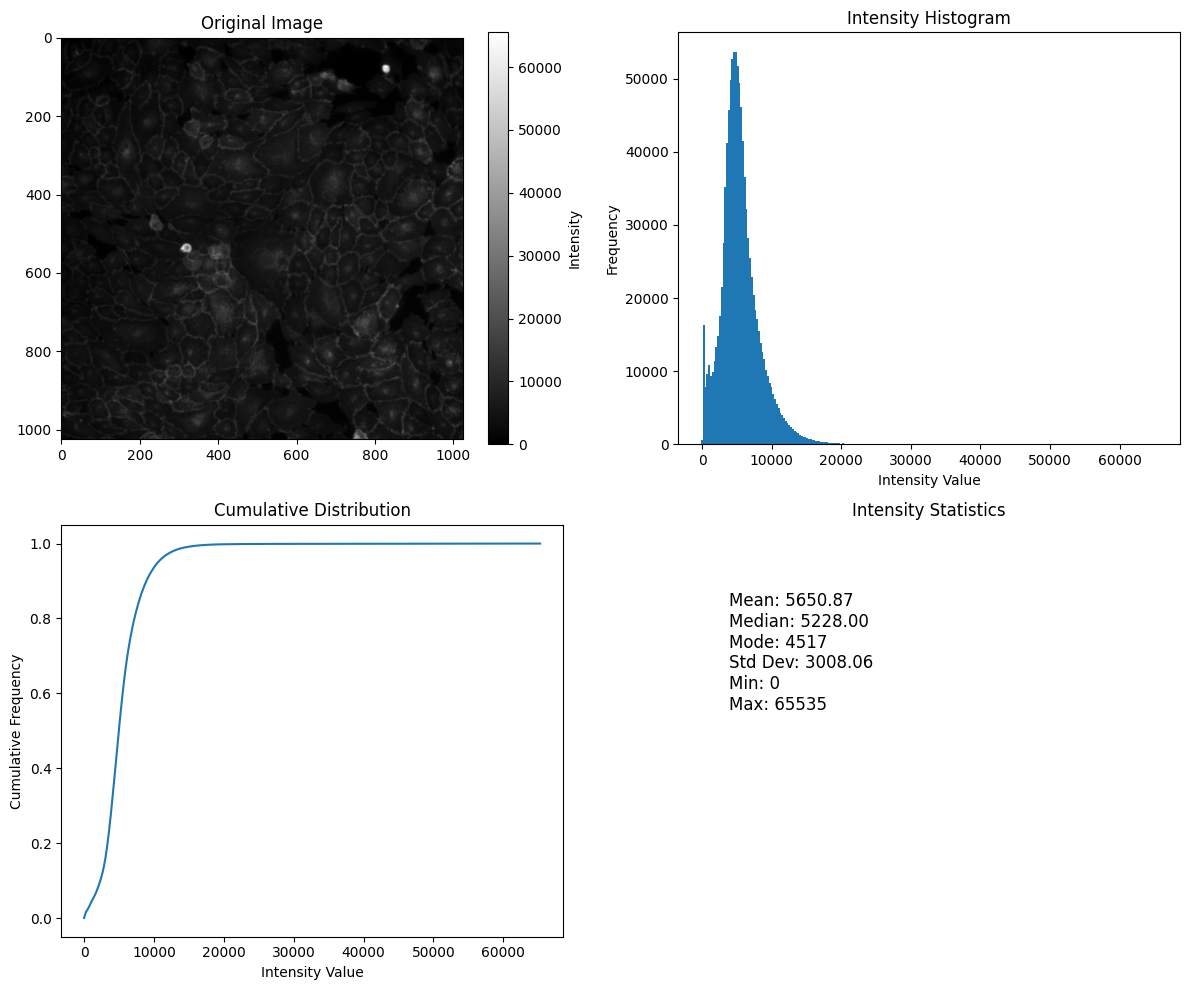

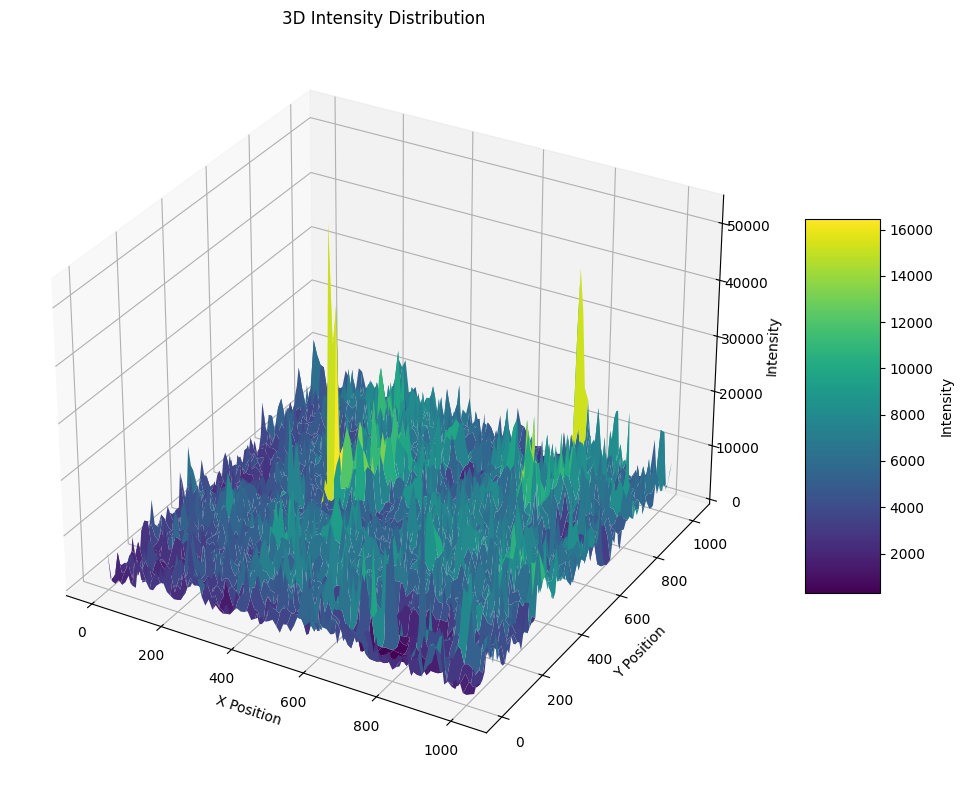

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from scipy import stats

# Load the TIF image
image = io.imread('image.tif')

# If the image has multiple channels (RGB), convert to grayscale
if len(image.shape) > 2 and image.shape[2] > 1:
    # Simple conversion to grayscale by averaging channels
    image_gray = np.mean(image, axis=2).astype(image.dtype)
else:
    image_gray = image

# Display the original image
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.imshow(image_gray, cmap='gray')
plt.title('Original Image')
plt.colorbar(label='Intensity')

# Create a histogram of intensity values
plt.subplot(2, 2, 2)
hist, bins = np.histogram(image_gray.flatten(), bins=256, range=(0, image_gray.max()))
plt.bar(bins[:-1], hist, width=bins[1]-bins[0])
plt.title('Intensity Histogram')
plt.xlabel('Intensity Value')
plt.ylabel('Frequency')

# Calculate and display cumulative distribution
plt.subplot(2, 2, 3)
cdf = hist.cumsum() / hist.sum()
plt.plot(bins[:-1], cdf)
plt.title('Cumulative Distribution')
plt.xlabel('Intensity Value')
plt.ylabel('Cumulative Frequency')

# Display basic statistics
mean_val = np.mean(image_gray)
median_val = np.median(image_gray)
std_val = np.std(image_gray)
mode_val = stats.mode(image_gray.flatten(), keepdims=True)[0][0]

plt.subplot(2, 2, 4)
plt.axis('off')
stats_text = (f"Mean: {mean_val:.2f}\n"
              f"Median: {median_val:.2f}\n"
              f"Mode: {mode_val}\n"
              f"Std Dev: {std_val:.2f}\n"
              f"Min: {np.min(image_gray)}\n"
              f"Max: {np.max(image_gray)}\n")
plt.text(0.1, 0.5, stats_text, fontsize=12)
plt.title('Intensity Statistics')

plt.tight_layout()
plt.show()

# Create a 3D surface plot to visualize intensity distribution spatially
plt.figure(figsize=(10, 8))
from mpl_toolkits.mplot3d import Axes3D

# Downsample the image if it's too large for the 3D plot
sampling = max(1, image_gray.shape[0] // 100, image_gray.shape[1] // 100)
x = np.arange(0, image_gray.shape[1], sampling)
y = np.arange(0, image_gray.shape[0], sampling)
X, Y = np.meshgrid(x, y)
Z = image_gray[::sampling, ::sampling]

ax = plt.axes(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', linewidth=0)
plt.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Intensity')
ax.set_title('3D Intensity Distribution')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Intensity')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from scipy.signal import find_peaks, savgol_filter

# Load the TIF image
image = io.imread('image.tif')

# If the image has multiple channels (RGB), convert to grayscale
if len(image.shape) > 2 and image.shape[2] > 1:
    # Simple conversion to grayscale by averaging channels
    image_gray = np.mean(image, axis=2).astype(image.dtype)
else:
    image_gray = image

# Create a histogram of intensity values
hist, bins = np.histogram(image_gray.flatten(), bins=256, range=(0, np.max(image_gray)))

# Find the peak intensity (mode)
peak_idx = np.argmax(hist)
peak_value = bins[peak_idx]
print(f"Peak found at intensity value: {peak_value}")

# Apply a smoothing filter to the histogram to reduce noise
# This helps in identifying the true valleys
hist_smooth = savgol_filter(hist, window_length=11, polyorder=3)

# Find valleys (local minima) in the smoothed histogram
# We invert the histogram because find_peaks finds maxima
valleys, _ = find_peaks(-hist_smooth)

# Find valleys to the left of the peak
valleys_left = valleys[valleys < peak_idx]

# If there are valleys to the left, find the closest one to the peak
if len(valleys_left) > 0:
    first_valley_idx = valleys_left[-1]  # Last

Peak found at intensity value: 4607.9296875


Peak found at intensity value: 4607.9296875
First valley found at intensity value: 1535.9765625


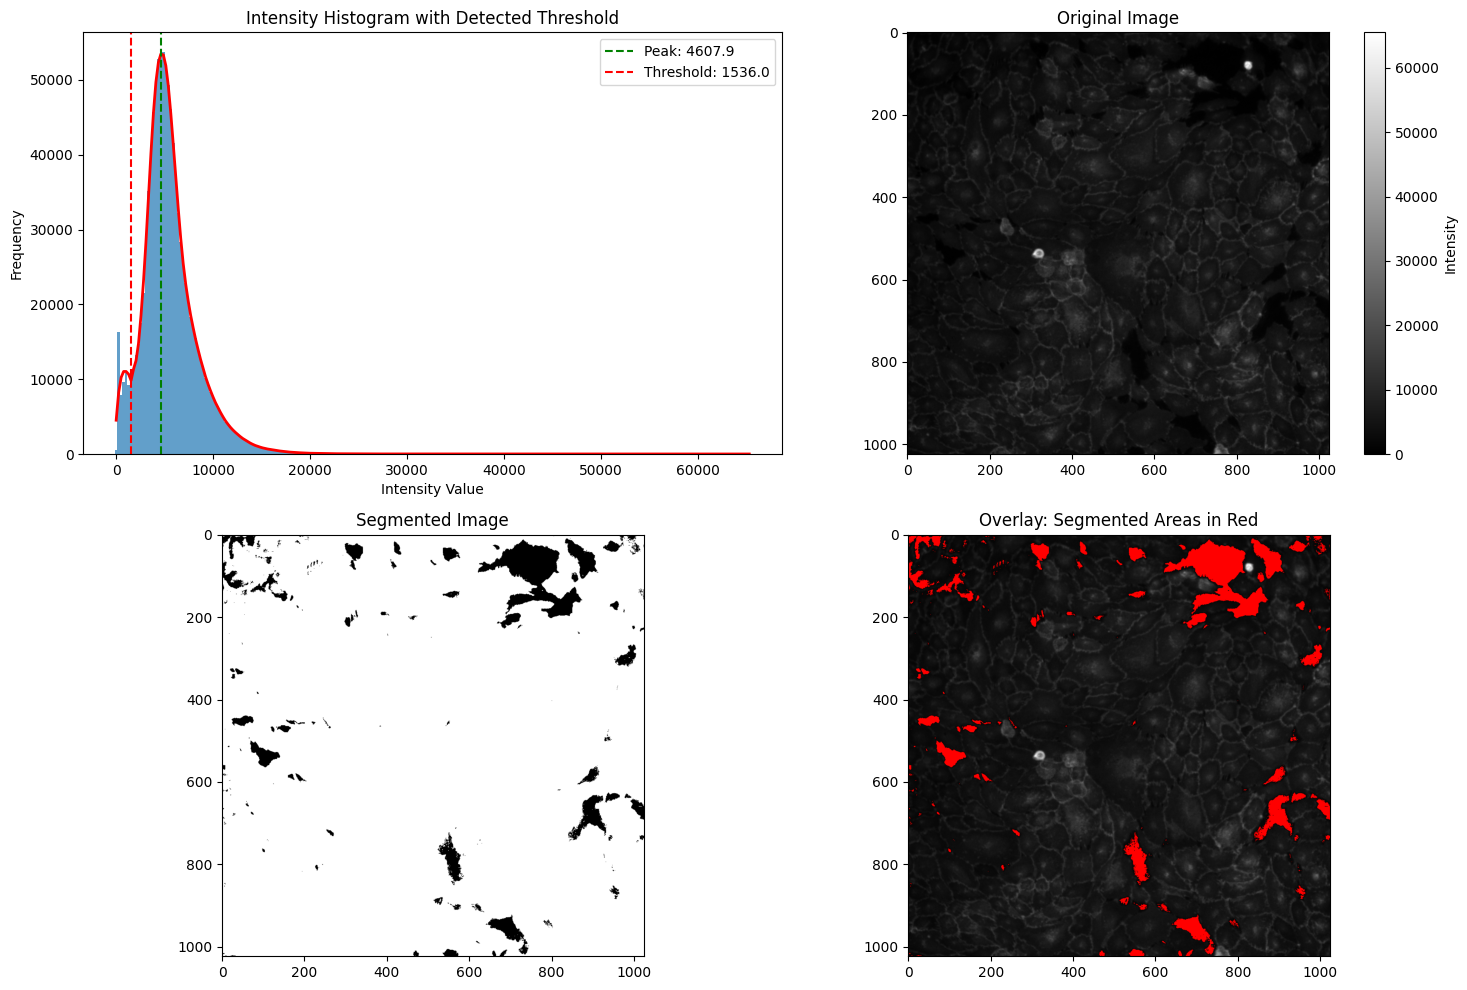

Segmentation complete. Threshold value: 1535.9765625


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from scipy.signal import find_peaks, savgol_filter

# Load the TIF image
image = io.imread('image.tif')

# If the image has multiple channels (RGB), convert to grayscale
if len(image.shape) > 2 and image.shape[2] > 1:
    # Simple conversion to grayscale by averaging channels
    image_gray = np.mean(image, axis=2).astype(image.dtype)
else:
    image_gray = image

# Create a histogram of intensity values
hist, bins = np.histogram(image_gray.flatten(), bins=256, range=(0, np.max(image_gray)))

# Find the peak intensity (mode)
peak_idx = np.argmax(hist)
peak_value = bins[peak_idx]
print(f"Peak found at intensity value: {peak_value}")

# Apply a smoothing filter to the histogram to reduce noise
# This helps in identifying the true valleys
hist_smooth = savgol_filter(hist, window_length=11, polyorder=3)

# Find valleys (local minima) in the smoothed histogram
# We invert the histogram because find_peaks finds maxima
valleys, _ = find_peaks(-hist_smooth)

# Find valleys to the left of the peak
valleys_left = valleys[valleys < peak_idx]

# If there are valleys to the left, find the closest one to the peak
if len(valleys_left) > 0:
    first_valley_idx = valleys_left[-1]  # Last valley to the left of the peak
    valley_value = bins[first_valley_idx]
    threshold = valley_value
    print(f"First valley found at intensity value: {valley_value}")
else:
    # If no valleys are found, use a fallback method
    # For example, find where the histogram drops to 50% of the peak height
    half_height = hist[peak_idx] * 0.5
    for i in range(peak_idx, -1, -1):
        if hist[i] < half_height:
            threshold = bins[i]
            print(f"No clear valley found. Using 50% peak height threshold: {threshold}")
            break
    else:
        threshold = bins[0]
        print("Using minimum value as threshold")

# Apply thresholding to segment the image
segmented = np.zeros_like(image_gray)
segmented[image_gray <= threshold] = 1  # Segment pixels with intensity <= threshold

# Visualization
plt.figure(figsize=(15, 10))

# Plot the original histogram with the detected peak and valley
plt.subplot(2, 2, 1)
plt.bar(bins[:-1], hist, width=bins[1] - bins[0], alpha=0.7)
plt.plot(bins[:-1], hist_smooth, 'r-', linewidth=2)
plt.axvline(x=peak_value, color='g', linestyle='--', label=f'Peak: {peak_value:.1f}')
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.1f}')
plt.title('Intensity Histogram with Detected Threshold')
plt.xlabel('Intensity Value')
plt.ylabel('Frequency')
plt.legend()

# Display the original image
plt.subplot(2, 2, 2)
plt.imshow(image_gray, cmap='gray')
plt.colorbar(label='Intensity')
plt.title('Original Image')

# Display the segmented image
plt.subplot(2, 2, 3)
plt.imshow(segmented, cmap='binary')
plt.title('Segmented Image')

# Show a comparison of the original and segmented images
plt.subplot(2, 2, 4)
overlay = np.zeros((*image_gray.shape, 3), dtype=np.uint8)
# Original in grayscale
overlay[..., 0] = overlay[..., 1] = overlay[..., 2] = (image_gray / np.max(image_gray) * 255).astype(np.uint8)
# Segmented areas in red
overlay[segmented == 1, 0] = 255  # Red channel
overlay[segmented == 1, 1] = 0    # Green channel
overlay[segmented == 1, 2] = 0    # Blue channel
plt.imshow(overlay)
plt.title('Overlay: Segmented Areas in Red')

plt.tight_layout()
plt.show()

# Optional: Save the segmented image
io.imsave('segmented_image.tif', segmented.astype(np.uint8) * 255)

print(f"Segmentation complete. Threshold value: {threshold}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from scipy import ndimage
from scipy.signal import find_peaks, savgol_filter
import os
import glob
from google.colab import drive

# Mount Google Drive if using Colab
try:
    drive.mount('/content/drive')
    USING_COLAB = True
except:
    USING_COLAB = False
    print("Not running in Colab, skipping drive mount")

# Define the input and output paths
# Change these to match your directory structure
if USING_COLAB:
    input_dir = '/content/drive/MyDrive/knowledge/University/Master/Thesis/Projected/holes_1.4Pa-A-2/WNLA/'
    output_dir = '/content/drive/MyDrive/knowledge/University/Master/Thesis/Projected/holes_1.4Pa-A-2/WWLA_Segmented/'
else:
    # Local paths (change these as needed)
    input_dir = './'
    output_dir = './segmented/'

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Find all processed files in the input directory
processed_files = glob.glob(os.path.join(input_dir, "*_hole_projection.tif"))

# If no specific files found, look for any TIF files
if len(processed_files) == 0:
    processed_files = glob.glob(os.path.join(input_dir, "*.tif"))

print(f"Found {len(processed_files)} TIF files to process")
if len(processed_files) == 0:
    print("No TIF files found. Please check the input directory.")
    # Option to look for other file types
    all_files = glob.glob(os.path.join(input_dir, "*"))
    if len(all_files) > 0:
        print(f"Found {len(all_files)} files of other types in the directory.")
        print("Available files:")
        for file in all_files:
            print(f" - {os.path.basename(file)}")

# Function to apply illumination correction
def apply_illumination_correction(img):
    # Normalize image to [0, 1] range for processing
    img_min = np.min(img)
    img_max = np.max(img)
    if img_max > img_min:  # Check to prevent division by zero
        img_norm = (img - img_min) / (img_max - img_min)
    else:
        img_norm = img.astype(float)
        print("  Warning: Image has constant values, normalization skipped")

    # Estimate background using a large Gaussian filter
    print("Applying illumination correction via division method...")
    sigma = max(img_norm.shape) // 20  # Divisor of 20 for division method
    print(f"  Using Gaussian filter with sigma = {sigma}")

    # Apply Gaussian filter to estimate background
    background = ndimage.gaussian_filter(img_norm, sigma=sigma)

    # Use DIVISION instead of subtraction to correct illumination
    illumination_corrected = img_norm / (background + 1e-6)  # Adding small value to prevent division by zero

    # Normalize the result to [0, 1] range
    illumination_min = np.min(illumination_corrected)
    illumination_max = np.max(illumination_corrected)
    if illumination_max > illumination_min:  # Check to prevent division by zero
        illumination_corrected = (illumination_corrected - illumination_min) / (illumination_max - illumination_min)

    return illumination_corrected

# Function to find threshold using valley-based method
def find_valley_threshold(img):
    # Create a histogram of intensity values
    hist, bins = np.histogram(img.flatten(), bins=256, range=(0, 1))

    # Find the peak intensity (mode)
    peak_idx = np.argmax(hist)
    peak_value = bins[peak_idx]
    print(f"Peak found at intensity value: {peak_value:.4f}")

    # Apply a smoothing filter to the histogram to reduce noise
    hist_smooth = savgol_filter(hist, window_length=11, polyorder=3)

    # Find valleys (local minima) in the smoothed histogram
    # We invert the histogram because find_peaks finds maxima
    valleys, _ = find_peaks(-hist_smooth)

    # Find valleys to the left of the peak
    valleys_left = valleys[valleys < peak_idx]

    # If there are valleys to the left, find the closest one to the peak
    if len(valleys_left) > 0:
        first_valley_idx = valleys_left[-1]  # Last valley to the left of the peak
        valley_value = bins[first_valley_idx]
        threshold = valley_value
        print(f"First valley found at intensity value: {valley_value:.4f}")
    else:
        # If no valleys are found, use a fallback method
        # Find where the histogram drops to 50% of the peak height
        half_height = hist[peak_idx] * 0.5
        for i in range(peak_idx, -1, -1):
            if hist[i] < half_height:
                threshold = bins[i]
                print(f"No clear valley found. Using 50% peak height threshold: {threshold:.4f}")
                break
        else:
            threshold = bins[0]
            print("Using minimum value as threshold")

    return threshold, hist, hist_smooth, bins, peak_idx, valleys_left

# Process each file
for file_path in processed_files:
    filename = os.path.basename(file_path)
    print(f"\nProcessing: {filename}")

    # Load the image
    try:
        img = tifffile.imread(file_path)
        print(f"Image loaded successfully, shape: {img.shape}, dtype: {img.dtype}")
    except Exception as e:
        print(f"Error loading image {filename}: {e}")
        print("Skipping to next file")
        continue

    # Apply illumination correction
    illumination_corrected = apply_illumination_correction(img)

    # Find threshold using the valley-based method
    threshold, hist, hist_smooth, bins, peak_idx, valleys_left = find_valley_threshold(illumination_corrected)

    # Apply thresholding to segment the image
    segmented = np.zeros_like(illumination_corrected)
    segmented[illumination_corrected <= threshold] = 1  # Segment pixels with intensity <= threshold

    # Visualization
    plt.figure(figsize=(15, 10))

    # Plot the original histogram with the detected peak and valley
    plt.subplot(2, 2, 1)
    plt.bar(bins[:-1], hist, width=bins[1] - bins[0], alpha=0.7)
    plt.plot(bins[:-1], hist_smooth, 'r-', linewidth=2)
    peak_value = bins[peak_idx]
    plt.axvline(x=peak_value, color='g', linestyle='--', label=f'Peak: {peak_value:.4f}')
    plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.4f}')
    if len(valleys_left) > 0:
        for valley_idx in valleys_left:
            plt.axvline(x=bins[valley_idx], color='y', linestyle=':', alpha=0.5)
    plt.title('Intensity Histogram with Detected Threshold')
    plt.xlabel('Intensity Value')
    plt.ylabel('Frequency')
    plt.legend()

    # Display the original image
    plt.subplot(2, 2, 2)
    plt.imshow(illumination_corrected, cmap='gray')
    plt.colorbar(label='Intensity')
    plt.title('Illumination Corrected Image')

    # Display the segmented image
    plt.subplot(2, 2, 3)
    plt.imshow(segmented, cmap='binary')
    plt.title('Segmented Image')

    # Show a comparison of the original and segmented images
    plt.subplot(2, 2, 4)
    # Create an RGB image for overlay
    overlay = np.zeros((*illumination_corrected.shape, 3))
    # Original in grayscale
    for i in range(3):
        overlay[..., i] = illumination_corrected
    # Segmented areas in red
    overlay[segmented == 1, 0] = 1  # Red channel
    overlay[segmented == 1, 1] = 0  # Green channel
    overlay[segmented == 1, 2] = 0  # Blue channel
    plt.imshow(overlay)
    plt.title('Overlay: Segmented Areas in Red')

    plt.tight_layout()

    # Save the visualization
    vis_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_visualization.png")
    plt.savefig(vis_path, dpi=300)
    print(f"  Saved visualization to: {vis_path}")
    plt.close()

    # Save the illumination corrected image
    illum_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_illumination_corrected.tif")
    tifffile.imwrite(illum_path, illumination_corrected.astype(np.float32))
    print(f"  Saved illumination corrected image to: {illum_path}")

    # Save the segmented image
    seg_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_segmented.tif")
    tifffile.imwrite(seg_path, segmented.astype(np.uint8))
    print(f"  Saved segmented image to: {seg_path}")

print("\nAll processing completed!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1 TIF files to process

Processing: denoised_1.4Pa_A1_20dec21_20xA_L2RA_FlatA_seq018 (2)_hole_projection.tif
Image loaded successfully, shape: (1024, 1024), dtype: float32
Applying illumination correction via division method...
  Using Gaussian filter with sigma = 51
Peak found at intensity value: 0.0469
First valley found at intensity value: 0.0156
  Saved visualization to: /content/drive/MyDrive/knowledge/University/Master/Thesis/Projected/holes_1.4Pa-A-2/WWLA_Segmented/denoised_1.4Pa_A1_20dec21_20xA_L2RA_FlatA_seq018 (2)_hole_projection_visualization.png
  Saved illumination corrected image to: /content/drive/MyDrive/knowledge/University/Master/Thesis/Projected/holes_1.4Pa-A-2/WWLA_Segmented/denoised_1.4Pa_A1_20dec21_20xA_L2RA_FlatA_seq018 (2)_hole_projection_illumination_corrected.tif
  Saved segmented image to: /content/drive/MyDrive/knowledge/Univ